## Load Data Set

In [1]:
import zipfile
import os
import numpy as np
import pathlib
import pandas as pd
from math import ceil
import tensorflow as tf
import numpy as np
import IPython.display as display
import keras
from keras import backend as K
from matplotlib import pyplot as plt
from keras.utils import to_categorical


print(tf.__version__)


root_path = './'

models_path = os.path.join(root_path, 'saved_models_mnist_v9')
if not os.path.exists(models_path):
    os.mkdir(models_path)


mnist = keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = (x_train / 127.5) - 1, (x_test / 127.5) - 1


BATCH_SIZE = 256

Using TensorFlow backend.


1.13.1


In [2]:
print(x_train.shape, y_train.shape)
x_train = np.expand_dims(x_train, -1)
y_train = to_categorical(y_train)
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)
(60000, 28, 28, 1) (60000, 10)


In [3]:
def custom_loader():

  trainset_size = x_train.shape[0]

  p = 0
  while True:

    idx_from = (p * BATCH_SIZE) % trainset_size

    idx_to = idx_from + BATCH_SIZE

    batch_x = x_train[idx_from: idx_to]
    batch_y = y_train[idx_from: idx_to]
    
    p += 1
  
    yield batch_x, batch_y

In [4]:
custom_gen = custom_loader()
for i in range(3):
  batch_x, batch_y = next(custom_gen)
  print(batch_x.shape, batch_y.shape)

(256, 28, 28, 1) (256, 10)
(256, 28, 28, 1) (256, 10)
(256, 28, 28, 1) (256, 10)


## Model Design

In [5]:
enc_len = 0
age_len = 10
img_shape = (28, 28, 1)
width, height, depth = (28, 28, 1)
img_len = np.prod(img_shape)
latent_dim = enc_len + age_len + img_len
noise_len = 50  # 32 x 32 x 3
input_dim = enc_len + age_len + noise_len
cond_len = enc_len + age_len


def build_discriminator():
    conv = keras.Sequential([
        # conv block 1
        keras.layers.Conv2D(
            filters=16,
            kernel_size=(3, 3),
            strides=2,
            input_shape=img_shape
        ),
        keras.layers.Activation(tf.nn.leaky_relu),
        keras.layers.BatchNormalization(),

        # conv block 2
        keras.layers.Conv2D(
            filters=32,
            kernel_size=(3, 3),
            strides=2
        ),
        keras.layers.Activation(tf.nn.leaky_relu),
        keras.layers.BatchNormalization(),
        
        # conv block 3
        keras.layers.Conv2D(
            filters=3,
            kernel_size=(3, 3),
            strides=2
        ),
        keras.layers.Activation(tf.nn.leaky_relu),
    ])
    
    print("D M1:")
    conv.summary()
    
    model = keras.Sequential([
        # output
        keras.layers.Dense(1, input_shape=(age_len+12,)),
        keras.layers.Activation(tf.nn.sigmoid),
    ])
    
    clf = keras.Sequential([
        # output
        keras.layers.Dense(age_len, input_shape=(age_len+12,)),
        keras.layers.Activation(tf.nn.softmax),
    ])
    
    print("D M2:")
    model.summary()
    
    # condition
#     c1 = keras.layers.Input(shape=(enc_len,))
    c2 = keras.layers.Input(shape=(age_len,))
    
    # image
    z = keras.layers.Input(shape=img_shape)
    
    # convolution
    zout = conv(z)
    
    # flatten image
    z_flat = keras.layers.Flatten()(zout)
    
    # concatenation
    inputs = keras.layers.concatenate([c2, z_flat])
    
    # real or fake
    outputs = model(inputs)
    
    # 0, 1, 2, 3, .. 9
    lbl = clf(inputs)
    
    return keras.models.Model([c2, z], [outputs, lbl])


def build_generator():
    
    conv = keras.Sequential([
        # transpose conv block 1
        keras.layers.Conv2DTranspose(
            filters=16,
            kernel_size=(3, 3),
            strides=1,
            input_shape=(11, 11, 1)
        ),
        keras.layers.Activation(tf.nn.relu),
        keras.layers.BatchNormalization(),
        
        # transpose conv block 2
        keras.layers.Conv2DTranspose(
            filters=32,
            kernel_size=(3, 3),
            strides=2
        ),
        keras.layers.Activation(tf.nn.relu),
        keras.layers.BatchNormalization(),
        
        # transpose conv block 3
        keras.layers.Conv2DTranspose(
            filters=32,
            kernel_size=(2, 2),
            strides=1
        ),
        keras.layers.Activation(tf.nn.relu),
        keras.layers.BatchNormalization(),

        # transpose conv block 4
        keras.layers.Conv2DTranspose(
            filters=1,
            kernel_size=(1, 1),
            strides=1
        ),
        
        # output
        keras.layers.Activation(tf.nn.tanh)
    ])
    
    print("G M2:")
    conv.summary()
    
    model = keras.Sequential([
        # dense 1
        keras.layers.Dense(121, input_shape=(input_dim,)),
        keras.layers.Activation(tf.nn.relu),
        
        # reshape 1d to 3d
        keras.layers.Reshape((11, 11, 1))
    ])
    
    print("G M1:")
    model.summary()
    
    # condition
#     c1 = keras.layers.Input(shape=(enc_len,))
    c2 = keras.layers.Input(shape=(age_len,))
    
    # noise
    x = keras.layers.Input(shape=(noise_len,))

    # concatenation
    inputs = keras.layers.concatenate([c2, x])
    
    # flat dense output
    out_1 = model(inputs)
    
    # transpose conv output
    outputs = conv(out_1)
    
    return keras.models.Model([c2, x], outputs)


discriminator = build_discriminator()
generator = build_generator()

Instructions for updating:
Colocations handled automatically by placer.
D M1:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 13, 13, 16)        160       
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          4640      
_________________________________________________________________
activation_2 (Activation)    (None, 6, 6, 32)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 6, 6, 32)          128       
________________________________________________________________

In [6]:
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 60)           0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 11, 11, 1)    7381        concatenate_2[0][0]              
__________

In [7]:
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2, 2, 3)      5859        input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 12)           0           sequential_1[1][0]               
__________________________________________________________________________________________________
concatenat

## Generative Adversarial Network

In [8]:
GLR = 0.0009  # generator
DLR = 0.0009  # discriminator


# Wasserstein
def d_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)


discriminator.compile(
    optimizer=keras.optimizers.Adam(DLR, 0.5),
    loss=[keras.losses.binary_crossentropy, keras.losses.categorical_crossentropy],
    metrics=['accuracy']
)


# condition
# c1 = keras.layers.Input(shape=(enc_len,))
c2 = keras.layers.Input(shape=(age_len,))

# noise
x = keras.layers.Input(shape=(noise_len,))

# freeze discriminator
discriminator.trainable = False

# output
z = generator([c2, x])
out, lbl = discriminator([c2, z])

# GAN
gan = keras.models.Model(inputs=[c2, x], outputs=[out, lbl])

gan.compile(
    optimizer=keras.optimizers.Adam(GLR , 0.5),
    loss=[keras.losses.binary_crossentropy, keras.losses.categorical_crossentropy],
    metrics=['accuracy'])

In [9]:
gan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 28, 28, 1)    16662       input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 [(None, 1), (None, 1 6112        input_5[0][0]                    
          

## Visualization Method

In [10]:
# from google.colab import drive
import os


# drive.mount('/content/gdrive', force_remount=True)

root_path = './'
tgt_pth = os.path.join(root_path, 'visualize_mnist-v22')

if not os.path.exists(tgt_pth):
  os.mkdir(tgt_pth)

In [11]:
def visualizeGAN(e, z_real, z_fake, conditions=None):

    fig, axes = plt.subplots(2, 5, figsize=(20, 10))

    r_real = 0
    r_fake = 0
    for row, axe in enumerate(axes):
        for col, cell in enumerate(axe):
            if row % 2 == 0 and z_real is not None:
                cell.imshow(
                    np.squeeze(
                        0.5 * z_real[r_real * 4 + col] + 0.5,
                        axis=-1
                    ),
                    cmap='gray'
                )
            else:
                cell.imshow(
                    np.squeeze(
                        0.5 * z_fake[r_fake * 5 + col] + 0.5,
                        axis=-1
                    ),
                    cmap='gray'
                )
                cell.set_title(
                    str(
                        np.argmax(
                            conditions[r_fake * 5 + col]
                        )
                    ) + ": " + str(
                        conditions[r_fake * 5 + col]
                    )
                )

            cell.axis("off")

        if row % 2 == 0 and z_real is not None:
            r_real += 1
        else:
            r_fake += 1

    plt.axis("off")
    plt.tight_layout()

    fig.savefig(os.path.join(tgt_pth, '{}.jpg'.format(str(e).zfill(3))))
    
    plt.close()

## Load Batch

In [12]:
def load_noise():
    
    y_true = tf.ones((BATCH_SIZE,))
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allocator_type = 'BFC'
    config.gpu_options.per_process_gpu_memory_fraction = 0.40

    with tf.Session(config=config) as sess:
        tf.initialize_all_variables().run()
        
        # run once
        y_true = y_true.eval()

        while True:
            batch_x, batch_y = next(custom_gen)

            sz = batch_x.shape[0]

            if sz != BATCH_SIZE:
                continue
            
            # fake data
            c2 = tf.cast(batch_y, tf.float32).eval()
            x = tf.random.normal((sz, noise_len,)).eval()
            
            yield c2, x, y_true


def load_batch():
    
    y_fake = tf.zeros((BATCH_SIZE,))
    y_true = tf.ones((BATCH_SIZE,))
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allocator_type = 'BFC'
    config.gpu_options.per_process_gpu_memory_fraction = 0.40

    with tf.Session(config=config) as sess:
        tf.initialize_all_variables().run()
        
        # run once
        y_fake = y_fake.eval()
        y_true = y_true.eval()

        while True:
            batch_x, batch_y = next(custom_gen)

            sz = batch_x.shape[0]

            if sz != BATCH_SIZE:
                continue
            
            # fake data
            c2 = tf.cast(batch_y, tf.float32).eval()
            x = tf.random.normal((sz, noise_len,)).eval()
            z_fake = generator.predict([c2, x])

            # real data
            c2 = tf.cast(batch_y, tf.float32).eval()
            z_real = batch_x
                        
            yield c2, x, z_fake, y_fake, z_real, y_true

## Train Model

In [13]:
EPOCHS = 6000
STEPS = 1  # 60000 // BATCH_SIZE


train_loss_g = []
train_loss_d = []

train_acc_g = []
train_acc_d = []


disc_itr = load_batch()
gen_itr = load_noise()


# fixed test sample
noise = np.random.normal(size=(age_len, noise_len,) )
conditions = np.identity(age_len)


# epochs
for e in range(EPOCHS):

    #batches
    loss = []
    acc = []

    for p in range(STEPS):
        
        c2, x, z_fake, y_fake, z_real, y_real = next(disc_itr)
    
        # train
        ## ['loss', 'model_1_loss', 'model_1_loss', 'model_1_acc', 'model_1_acc_1']
        loss_1, _, _, acc_1, _ = discriminator.train_on_batch([c2, z_real], [y_real, c2])
        loss_2, _, _, acc_2, _ = discriminator.train_on_batch([c2, z_fake], [y_fake, c2])

        batch_loss = 0.5 * (loss_1 + loss_2)
        batch_acc = 0.5 * (acc_1 + acc_2)

        loss.append(batch_loss)
        acc.append(batch_acc)

    train_loss_d.append(np.mean(np.array(loss)))
    train_acc_d.append(np.mean(np.array(acc)))

    #batches
    loss = []
    acc = []

    for p in range(STEPS):

      c2, x, y_true = next(gen_itr)

      # train
      ## ['loss', 'model_1_loss', 'model_1_loss', 'model_1_acc', 'model_1_acc_1']
      loss_1, _, _, acc_1, _ = gan.train_on_batch([c2, x], [y_true, c2])

      loss.append(loss_1)
      acc.append(acc_1)

    train_loss_g.append(np.mean(np.array(loss)))
    train_acc_g.append(np.mean(np.array(acc)))


    print("E: {}, D:[ACC: %{:.2f}, LOSS: {:.2f}], G:[ACC: %{:.2f}, LOSS: {:.2f}]".format(
          e,
          train_acc_d[-1] * 100,
          train_loss_d[-1] * 100,
          train_acc_g[-1] * 100,
          train_loss_g[-1] * 100
      ))

    if e % 200 == 0:
        ## visualize results
        synthesized = generator.predict([conditions, noise])
        visualizeGAN(e, None, synthesized, conditions)
        
        ## save model
        pth = os.path.join(models_path, 'gan.h5')
        gan.save(pth)

        pth = os.path.join(models_path, 'generator-{}-{}-{}.h5'.format(e, train_loss_g[-1], train_acc_g[-1]))
        generator.save(pth)

        pth = os.path.join(models_path, 'discriminator.h5')
        discriminator.save(pth)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


E: 0, D:[ACC: %43.75, LOSS: 353.01], G:[ACC: %31.25, LOSS: 369.67]
E: 1, D:[ACC: %44.92, LOSS: 339.64], G:[ACC: %31.64, LOSS: 355.92]
E: 2, D:[ACC: %55.86, LOSS: 315.23], G:[ACC: %23.44, LOSS: 357.88]
E: 3, D:[ACC: %65.23, LOSS: 300.24], G:[ACC: %31.25, LOSS: 342.24]
E: 4, D:[ACC: %70.90, LOSS: 287.19], G:[ACC: %30.86, LOSS: 335.99]
E: 5, D:[ACC: %73.44, LOSS: 283.77], G:[ACC: %30.08, LOSS: 337.03]
E: 6, D:[ACC: %74.80, LOSS: 272.01], G:[ACC: %35.55, LOSS: 335.04]
E: 7, D:[ACC: %72.66, LOSS: 270.46], G:[ACC: %40.62, LOSS: 315.56]
E: 8, D:[ACC: %67.19, LOSS: 271.55], G:[ACC: %47.66, LOSS: 307.39]
E: 9, D:[ACC: %69.92, LOSS: 263.88], G:[ACC: %51.56, LOSS: 306.24]
E: 10, D:[ACC: %66.80, LOSS: 263.83], G:[ACC: %51.17, LOSS: 308.33]
E: 11, D:[ACC: %67.97, LOSS: 261.36], G:[ACC: %46.48, LOSS: 306.61]
E: 12, D:[ACC: %65.04, LOSS: 265.37], G:[ACC: %53.52, LOSS: 296.70]
E: 13, D:[ACC: %64.26, LOSS: 264.97], G:[ACC: %55.08, LOSS: 297.01]
E: 14, D:[ACC: %65.23, LOSS: 262.86], G:[ACC: %50.39, LOSS

E: 121, D:[ACC: %85.16, LOSS: 179.13], G:[ACC: %18.36, LOSS: 315.39]
E: 122, D:[ACC: %83.01, LOSS: 178.74], G:[ACC: %18.36, LOSS: 307.70]
E: 123, D:[ACC: %84.38, LOSS: 171.57], G:[ACC: %19.53, LOSS: 313.95]
E: 124, D:[ACC: %82.81, LOSS: 180.50], G:[ACC: %19.92, LOSS: 326.69]
E: 125, D:[ACC: %83.79, LOSS: 180.84], G:[ACC: %18.75, LOSS: 326.72]
E: 126, D:[ACC: %86.33, LOSS: 178.76], G:[ACC: %16.80, LOSS: 330.27]
E: 127, D:[ACC: %85.55, LOSS: 172.93], G:[ACC: %14.45, LOSS: 326.10]
E: 128, D:[ACC: %79.88, LOSS: 184.92], G:[ACC: %18.36, LOSS: 321.53]
E: 129, D:[ACC: %85.94, LOSS: 178.85], G:[ACC: %15.62, LOSS: 333.00]
E: 130, D:[ACC: %85.74, LOSS: 183.11], G:[ACC: %17.58, LOSS: 323.66]
E: 131, D:[ACC: %84.77, LOSS: 184.91], G:[ACC: %14.06, LOSS: 337.14]
E: 132, D:[ACC: %85.55, LOSS: 189.08], G:[ACC: %19.14, LOSS: 336.42]
E: 133, D:[ACC: %85.94, LOSS: 178.04], G:[ACC: %15.62, LOSS: 332.84]
E: 134, D:[ACC: %84.57, LOSS: 178.10], G:[ACC: %18.75, LOSS: 325.41]
E: 135, D:[ACC: %86.13, LOSS: 178.

E: 241, D:[ACC: %75.39, LOSS: 168.06], G:[ACC: %41.41, LOSS: 271.85]
E: 242, D:[ACC: %69.34, LOSS: 173.95], G:[ACC: %39.45, LOSS: 263.72]
E: 243, D:[ACC: %73.63, LOSS: 165.47], G:[ACC: %37.11, LOSS: 275.74]
E: 244, D:[ACC: %71.29, LOSS: 166.56], G:[ACC: %37.11, LOSS: 263.24]
E: 245, D:[ACC: %68.55, LOSS: 174.99], G:[ACC: %31.64, LOSS: 281.79]
E: 246, D:[ACC: %72.07, LOSS: 169.73], G:[ACC: %38.28, LOSS: 266.34]
E: 247, D:[ACC: %63.67, LOSS: 179.43], G:[ACC: %40.62, LOSS: 259.15]
E: 248, D:[ACC: %61.13, LOSS: 180.98], G:[ACC: %38.28, LOSS: 265.62]
E: 249, D:[ACC: %77.73, LOSS: 160.28], G:[ACC: %22.66, LOSS: 291.90]
E: 250, D:[ACC: %65.23, LOSS: 172.17], G:[ACC: %29.30, LOSS: 280.19]
E: 251, D:[ACC: %75.78, LOSS: 158.37], G:[ACC: %27.34, LOSS: 280.48]
E: 252, D:[ACC: %72.27, LOSS: 165.94], G:[ACC: %21.88, LOSS: 290.53]
E: 253, D:[ACC: %78.52, LOSS: 155.22], G:[ACC: %32.42, LOSS: 266.41]
E: 254, D:[ACC: %77.93, LOSS: 150.43], G:[ACC: %36.72, LOSS: 259.65]
E: 255, D:[ACC: %67.77, LOSS: 169.

E: 360, D:[ACC: %46.29, LOSS: 147.89], G:[ACC: %27.73, LOSS: 203.22]
E: 361, D:[ACC: %69.73, LOSS: 118.86], G:[ACC: %18.75, LOSS: 222.66]
E: 362, D:[ACC: %61.33, LOSS: 134.65], G:[ACC: %18.75, LOSS: 215.04]
E: 363, D:[ACC: %66.99, LOSS: 130.76], G:[ACC: %21.88, LOSS: 212.02]
E: 364, D:[ACC: %56.64, LOSS: 142.81], G:[ACC: %20.70, LOSS: 212.09]
E: 365, D:[ACC: %41.80, LOSS: 156.06], G:[ACC: %23.83, LOSS: 202.98]
E: 366, D:[ACC: %68.36, LOSS: 123.10], G:[ACC: %11.72, LOSS: 234.77]
E: 367, D:[ACC: %63.67, LOSS: 136.93], G:[ACC: %17.58, LOSS: 212.90]
E: 368, D:[ACC: %59.77, LOSS: 134.76], G:[ACC: %25.39, LOSS: 191.17]
E: 369, D:[ACC: %66.99, LOSS: 124.43], G:[ACC: %16.02, LOSS: 213.28]
E: 370, D:[ACC: %59.96, LOSS: 127.30], G:[ACC: %17.58, LOSS: 220.11]
E: 371, D:[ACC: %62.70, LOSS: 134.69], G:[ACC: %20.31, LOSS: 198.54]
E: 372, D:[ACC: %53.91, LOSS: 138.33], G:[ACC: %23.44, LOSS: 194.88]
E: 373, D:[ACC: %65.23, LOSS: 127.60], G:[ACC: %15.62, LOSS: 218.36]
E: 374, D:[ACC: %51.95, LOSS: 146.

E: 479, D:[ACC: %60.94, LOSS: 108.92], G:[ACC: %20.70, LOSS: 157.17]
E: 480, D:[ACC: %60.55, LOSS: 104.88], G:[ACC: %21.09, LOSS: 160.14]
E: 481, D:[ACC: %63.09, LOSS: 111.14], G:[ACC: %26.56, LOSS: 154.94]
E: 482, D:[ACC: %53.12, LOSS: 119.16], G:[ACC: %29.30, LOSS: 142.84]
E: 483, D:[ACC: %62.30, LOSS: 104.66], G:[ACC: %17.19, LOSS: 166.37]
E: 484, D:[ACC: %59.38, LOSS: 105.72], G:[ACC: %21.48, LOSS: 160.27]
E: 485, D:[ACC: %51.56, LOSS: 109.37], G:[ACC: %19.53, LOSS: 154.98]
E: 486, D:[ACC: %61.52, LOSS: 102.61], G:[ACC: %21.09, LOSS: 157.03]
E: 487, D:[ACC: %61.33, LOSS: 107.72], G:[ACC: %14.45, LOSS: 173.23]
E: 488, D:[ACC: %55.86, LOSS: 112.40], G:[ACC: %16.80, LOSS: 157.88]
E: 489, D:[ACC: %62.70, LOSS: 106.08], G:[ACC: %16.41, LOSS: 163.57]
E: 490, D:[ACC: %64.65, LOSS: 104.55], G:[ACC: %10.55, LOSS: 174.71]
E: 491, D:[ACC: %56.45, LOSS: 110.19], G:[ACC: %18.75, LOSS: 149.86]
E: 492, D:[ACC: %62.11, LOSS: 105.13], G:[ACC: %14.45, LOSS: 165.52]
E: 493, D:[ACC: %56.45, LOSS: 112.

E: 599, D:[ACC: %56.64, LOSS: 98.86], G:[ACC: %14.45, LOSS: 142.62]
E: 600, D:[ACC: %60.16, LOSS: 92.53], G:[ACC: %11.72, LOSS: 152.52]
E: 601, D:[ACC: %66.02, LOSS: 86.91], G:[ACC: %15.23, LOSS: 143.27]
E: 602, D:[ACC: %61.33, LOSS: 89.42], G:[ACC: %14.45, LOSS: 137.32]
E: 603, D:[ACC: %55.86, LOSS: 91.51], G:[ACC: %20.31, LOSS: 129.92]
E: 604, D:[ACC: %61.13, LOSS: 87.80], G:[ACC: %11.33, LOSS: 145.48]
E: 605, D:[ACC: %55.86, LOSS: 95.27], G:[ACC: %17.19, LOSS: 136.43]
E: 606, D:[ACC: %60.35, LOSS: 91.72], G:[ACC: %12.11, LOSS: 144.92]
E: 607, D:[ACC: %54.30, LOSS: 96.88], G:[ACC: %17.58, LOSS: 139.55]
E: 608, D:[ACC: %60.55, LOSS: 88.41], G:[ACC: %12.89, LOSS: 139.87]
E: 609, D:[ACC: %61.33, LOSS: 94.02], G:[ACC: %14.45, LOSS: 144.79]
E: 610, D:[ACC: %64.45, LOSS: 93.48], G:[ACC: %13.67, LOSS: 136.62]
E: 611, D:[ACC: %60.55, LOSS: 94.10], G:[ACC: %16.80, LOSS: 138.97]
E: 612, D:[ACC: %58.59, LOSS: 89.86], G:[ACC: %11.33, LOSS: 144.07]
E: 613, D:[ACC: %56.45, LOSS: 103.44], G:[ACC: %

E: 720, D:[ACC: %57.62, LOSS: 82.47], G:[ACC: %18.36, LOSS: 125.36]
E: 721, D:[ACC: %65.82, LOSS: 85.19], G:[ACC: %15.62, LOSS: 128.04]
E: 722, D:[ACC: %50.59, LOSS: 95.24], G:[ACC: %18.36, LOSS: 124.65]
E: 723, D:[ACC: %59.96, LOSS: 87.35], G:[ACC: %14.45, LOSS: 125.83]
E: 724, D:[ACC: %60.16, LOSS: 91.50], G:[ACC: %17.58, LOSS: 122.84]
E: 725, D:[ACC: %57.03, LOSS: 90.58], G:[ACC: %14.84, LOSS: 124.08]
E: 726, D:[ACC: %50.00, LOSS: 98.79], G:[ACC: %15.23, LOSS: 124.90]
E: 727, D:[ACC: %57.81, LOSS: 100.28], G:[ACC: %12.89, LOSS: 132.63]
E: 728, D:[ACC: %61.52, LOSS: 85.44], G:[ACC: %10.55, LOSS: 136.34]
E: 729, D:[ACC: %61.91, LOSS: 84.63], G:[ACC: %17.19, LOSS: 127.05]
E: 730, D:[ACC: %58.79, LOSS: 85.22], G:[ACC: %17.97, LOSS: 124.66]
E: 731, D:[ACC: %63.09, LOSS: 86.52], G:[ACC: %12.89, LOSS: 132.82]
E: 732, D:[ACC: %66.80, LOSS: 82.46], G:[ACC: %12.50, LOSS: 143.91]
E: 733, D:[ACC: %55.47, LOSS: 94.06], G:[ACC: %17.19, LOSS: 124.83]
E: 734, D:[ACC: %60.35, LOSS: 84.43], G:[ACC: %

E: 841, D:[ACC: %61.52, LOSS: 82.30], G:[ACC: %17.58, LOSS: 124.31]
E: 842, D:[ACC: %59.38, LOSS: 84.41], G:[ACC: %18.75, LOSS: 122.02]
E: 843, D:[ACC: %55.47, LOSS: 89.18], G:[ACC: %17.58, LOSS: 119.34]
E: 844, D:[ACC: %61.33, LOSS: 92.80], G:[ACC: %16.80, LOSS: 126.72]
E: 845, D:[ACC: %61.33, LOSS: 78.86], G:[ACC: %14.06, LOSS: 127.19]
E: 846, D:[ACC: %59.57, LOSS: 88.40], G:[ACC: %18.36, LOSS: 121.54]
E: 847, D:[ACC: %61.33, LOSS: 78.54], G:[ACC: %17.19, LOSS: 120.29]
E: 848, D:[ACC: %61.52, LOSS: 84.35], G:[ACC: %12.11, LOSS: 128.81]
E: 849, D:[ACC: %64.84, LOSS: 80.68], G:[ACC: %15.23, LOSS: 124.87]
E: 850, D:[ACC: %59.77, LOSS: 86.94], G:[ACC: %19.53, LOSS: 129.76]
E: 851, D:[ACC: %57.42, LOSS: 87.04], G:[ACC: %15.62, LOSS: 117.82]
E: 852, D:[ACC: %66.41, LOSS: 77.61], G:[ACC: %18.36, LOSS: 119.41]
E: 853, D:[ACC: %55.08, LOSS: 88.26], G:[ACC: %19.53, LOSS: 116.56]
E: 854, D:[ACC: %60.35, LOSS: 83.56], G:[ACC: %12.50, LOSS: 126.34]
E: 855, D:[ACC: %61.13, LOSS: 82.88], G:[ACC: %2

E: 962, D:[ACC: %63.67, LOSS: 77.18], G:[ACC: %12.50, LOSS: 129.58]
E: 963, D:[ACC: %65.82, LOSS: 79.56], G:[ACC: %14.06, LOSS: 122.86]
E: 964, D:[ACC: %60.94, LOSS: 80.17], G:[ACC: %13.28, LOSS: 126.64]
E: 965, D:[ACC: %68.95, LOSS: 80.06], G:[ACC: %11.33, LOSS: 127.47]
E: 966, D:[ACC: %63.67, LOSS: 77.82], G:[ACC: %10.16, LOSS: 129.71]
E: 967, D:[ACC: %60.94, LOSS: 82.95], G:[ACC: %13.67, LOSS: 123.57]
E: 968, D:[ACC: %55.08, LOSS: 83.85], G:[ACC: %16.02, LOSS: 121.76]
E: 969, D:[ACC: %63.67, LOSS: 76.29], G:[ACC: %13.67, LOSS: 126.22]
E: 970, D:[ACC: %56.05, LOSS: 84.18], G:[ACC: %15.62, LOSS: 121.24]
E: 971, D:[ACC: %63.48, LOSS: 75.99], G:[ACC: %12.11, LOSS: 126.13]
E: 972, D:[ACC: %68.95, LOSS: 74.62], G:[ACC: %11.33, LOSS: 126.99]
E: 973, D:[ACC: %64.45, LOSS: 83.25], G:[ACC: %12.89, LOSS: 122.75]
E: 974, D:[ACC: %66.99, LOSS: 72.06], G:[ACC: %7.03, LOSS: 133.59]
E: 975, D:[ACC: %60.55, LOSS: 74.21], G:[ACC: %10.55, LOSS: 126.42]
E: 976, D:[ACC: %59.18, LOSS: 79.26], G:[ACC: %11

E: 1082, D:[ACC: %59.96, LOSS: 80.00], G:[ACC: %14.45, LOSS: 118.29]
E: 1083, D:[ACC: %62.50, LOSS: 78.50], G:[ACC: %16.41, LOSS: 118.50]
E: 1084, D:[ACC: %64.65, LOSS: 79.89], G:[ACC: %16.41, LOSS: 116.54]
E: 1085, D:[ACC: %56.25, LOSS: 83.57], G:[ACC: %14.06, LOSS: 116.12]
E: 1086, D:[ACC: %64.65, LOSS: 75.92], G:[ACC: %14.45, LOSS: 118.88]
E: 1087, D:[ACC: %53.52, LOSS: 84.55], G:[ACC: %17.19, LOSS: 112.15]
E: 1088, D:[ACC: %60.74, LOSS: 79.42], G:[ACC: %12.50, LOSS: 120.98]
E: 1089, D:[ACC: %57.81, LOSS: 79.87], G:[ACC: %13.67, LOSS: 123.92]
E: 1090, D:[ACC: %60.35, LOSS: 82.11], G:[ACC: %17.19, LOSS: 114.75]
E: 1091, D:[ACC: %63.28, LOSS: 76.04], G:[ACC: %16.80, LOSS: 121.31]
E: 1092, D:[ACC: %66.21, LOSS: 73.02], G:[ACC: %11.33, LOSS: 131.63]
E: 1093, D:[ACC: %54.10, LOSS: 88.36], G:[ACC: %13.28, LOSS: 116.76]
E: 1094, D:[ACC: %50.00, LOSS: 86.20], G:[ACC: %22.27, LOSS: 110.28]
E: 1095, D:[ACC: %56.05, LOSS: 81.79], G:[ACC: %19.53, LOSS: 104.96]
E: 1096, D:[ACC: %53.12, LOSS: 83.

E: 1201, D:[ACC: %52.15, LOSS: 82.08], G:[ACC: %17.19, LOSS: 108.55]
E: 1202, D:[ACC: %56.05, LOSS: 80.68], G:[ACC: %17.97, LOSS: 109.20]
E: 1203, D:[ACC: %61.33, LOSS: 78.74], G:[ACC: %21.88, LOSS: 106.00]
E: 1204, D:[ACC: %49.80, LOSS: 82.55], G:[ACC: %23.05, LOSS: 101.88]
E: 1205, D:[ACC: %59.18, LOSS: 78.50], G:[ACC: %14.45, LOSS: 118.03]
E: 1206, D:[ACC: %52.93, LOSS: 85.11], G:[ACC: %21.48, LOSS: 106.54]
E: 1207, D:[ACC: %64.45, LOSS: 72.44], G:[ACC: %18.36, LOSS: 114.77]
E: 1208, D:[ACC: %60.74, LOSS: 76.04], G:[ACC: %17.58, LOSS: 115.97]
E: 1209, D:[ACC: %59.38, LOSS: 77.80], G:[ACC: %13.28, LOSS: 117.88]
E: 1210, D:[ACC: %53.32, LOSS: 85.29], G:[ACC: %25.00, LOSS: 101.44]
E: 1211, D:[ACC: %57.03, LOSS: 79.60], G:[ACC: %21.48, LOSS: 109.15]
E: 1212, D:[ACC: %54.10, LOSS: 84.04], G:[ACC: %22.27, LOSS: 106.96]
E: 1213, D:[ACC: %52.93, LOSS: 82.38], G:[ACC: %23.83, LOSS: 104.94]
E: 1214, D:[ACC: %50.98, LOSS: 85.70], G:[ACC: %22.66, LOSS: 98.98]
E: 1215, D:[ACC: %45.31, LOSS: 83.5

E: 1320, D:[ACC: %53.32, LOSS: 79.19], G:[ACC: %23.05, LOSS: 102.95]
E: 1321, D:[ACC: %50.59, LOSS: 79.21], G:[ACC: %18.75, LOSS: 109.05]
E: 1322, D:[ACC: %56.45, LOSS: 78.86], G:[ACC: %24.22, LOSS: 104.71]
E: 1323, D:[ACC: %52.93, LOSS: 85.53], G:[ACC: %20.70, LOSS: 107.96]
E: 1324, D:[ACC: %60.35, LOSS: 73.25], G:[ACC: %19.14, LOSS: 104.42]
E: 1325, D:[ACC: %58.59, LOSS: 76.73], G:[ACC: %22.66, LOSS: 105.54]
E: 1326, D:[ACC: %52.34, LOSS: 81.01], G:[ACC: %32.42, LOSS: 96.51]
E: 1327, D:[ACC: %56.45, LOSS: 77.25], G:[ACC: %28.12, LOSS: 95.89]
E: 1328, D:[ACC: %53.32, LOSS: 78.19], G:[ACC: %23.05, LOSS: 103.97]
E: 1329, D:[ACC: %51.95, LOSS: 83.63], G:[ACC: %23.05, LOSS: 105.28]
E: 1330, D:[ACC: %61.72, LOSS: 75.97], G:[ACC: %16.80, LOSS: 107.17]
E: 1331, D:[ACC: %57.23, LOSS: 79.06], G:[ACC: %21.48, LOSS: 100.41]
E: 1332, D:[ACC: %51.76, LOSS: 81.29], G:[ACC: %23.05, LOSS: 102.17]
E: 1333, D:[ACC: %56.45, LOSS: 77.28], G:[ACC: %21.48, LOSS: 104.08]
E: 1334, D:[ACC: %58.01, LOSS: 81.50

E: 1440, D:[ACC: %54.30, LOSS: 80.66], G:[ACC: %19.14, LOSS: 99.89]
E: 1441, D:[ACC: %56.84, LOSS: 74.74], G:[ACC: %14.06, LOSS: 109.59]
E: 1442, D:[ACC: %58.98, LOSS: 73.51], G:[ACC: %16.80, LOSS: 106.82]
E: 1443, D:[ACC: %48.63, LOSS: 84.25], G:[ACC: %23.44, LOSS: 98.73]
E: 1444, D:[ACC: %50.20, LOSS: 81.25], G:[ACC: %32.03, LOSS: 94.73]
E: 1445, D:[ACC: %56.45, LOSS: 78.92], G:[ACC: %25.00, LOSS: 97.94]
E: 1446, D:[ACC: %48.83, LOSS: 81.41], G:[ACC: %26.95, LOSS: 93.79]
E: 1447, D:[ACC: %52.73, LOSS: 80.59], G:[ACC: %28.52, LOSS: 94.24]
E: 1448, D:[ACC: %57.42, LOSS: 75.91], G:[ACC: %15.23, LOSS: 102.68]
E: 1449, D:[ACC: %55.86, LOSS: 75.93], G:[ACC: %20.70, LOSS: 105.35]
E: 1450, D:[ACC: %52.15, LOSS: 78.79], G:[ACC: %21.48, LOSS: 100.16]
E: 1451, D:[ACC: %50.39, LOSS: 82.60], G:[ACC: %26.17, LOSS: 98.95]
E: 1452, D:[ACC: %57.42, LOSS: 76.58], G:[ACC: %19.53, LOSS: 105.90]
E: 1453, D:[ACC: %55.66, LOSS: 78.12], G:[ACC: %18.75, LOSS: 103.60]
E: 1454, D:[ACC: %57.42, LOSS: 77.99], G:

E: 1560, D:[ACC: %47.66, LOSS: 83.31], G:[ACC: %21.48, LOSS: 101.89]
E: 1561, D:[ACC: %52.34, LOSS: 78.27], G:[ACC: %28.91, LOSS: 95.21]
E: 1562, D:[ACC: %46.29, LOSS: 83.33], G:[ACC: %28.91, LOSS: 90.05]
E: 1563, D:[ACC: %46.88, LOSS: 81.99], G:[ACC: %28.91, LOSS: 94.03]
E: 1564, D:[ACC: %57.23, LOSS: 77.36], G:[ACC: %28.12, LOSS: 93.64]
E: 1565, D:[ACC: %48.83, LOSS: 79.88], G:[ACC: %21.88, LOSS: 100.63]
E: 1566, D:[ACC: %58.59, LOSS: 75.44], G:[ACC: %21.48, LOSS: 100.69]
E: 1567, D:[ACC: %55.86, LOSS: 76.33], G:[ACC: %24.22, LOSS: 96.63]
E: 1568, D:[ACC: %55.27, LOSS: 80.02], G:[ACC: %30.47, LOSS: 94.57]
E: 1569, D:[ACC: %53.52, LOSS: 76.81], G:[ACC: %24.22, LOSS: 97.79]
E: 1570, D:[ACC: %55.08, LOSS: 74.82], G:[ACC: %24.22, LOSS: 97.06]
E: 1571, D:[ACC: %55.66, LOSS: 79.10], G:[ACC: %23.83, LOSS: 100.75]
E: 1572, D:[ACC: %54.88, LOSS: 77.35], G:[ACC: %27.34, LOSS: 95.69]
E: 1573, D:[ACC: %45.12, LOSS: 84.09], G:[ACC: %27.34, LOSS: 92.87]
E: 1574, D:[ACC: %49.02, LOSS: 82.05], G:[AC

E: 1681, D:[ACC: %53.12, LOSS: 78.41], G:[ACC: %16.80, LOSS: 101.33]
E: 1682, D:[ACC: %53.32, LOSS: 77.79], G:[ACC: %25.78, LOSS: 92.38]
E: 1683, D:[ACC: %53.12, LOSS: 76.01], G:[ACC: %21.88, LOSS: 97.13]
E: 1684, D:[ACC: %56.05, LOSS: 79.07], G:[ACC: %21.88, LOSS: 99.78]
E: 1685, D:[ACC: %55.86, LOSS: 75.44], G:[ACC: %24.22, LOSS: 95.84]
E: 1686, D:[ACC: %58.40, LOSS: 73.25], G:[ACC: %24.61, LOSS: 99.16]
E: 1687, D:[ACC: %50.39, LOSS: 78.34], G:[ACC: %25.00, LOSS: 96.21]
E: 1688, D:[ACC: %55.27, LOSS: 77.97], G:[ACC: %22.66, LOSS: 98.20]
E: 1689, D:[ACC: %48.63, LOSS: 78.58], G:[ACC: %24.61, LOSS: 93.21]
E: 1690, D:[ACC: %56.25, LOSS: 74.10], G:[ACC: %20.70, LOSS: 99.80]
E: 1691, D:[ACC: %44.53, LOSS: 85.67], G:[ACC: %22.27, LOSS: 94.12]
E: 1692, D:[ACC: %53.71, LOSS: 78.61], G:[ACC: %21.48, LOSS: 92.96]
E: 1693, D:[ACC: %59.77, LOSS: 74.23], G:[ACC: %25.78, LOSS: 93.52]
E: 1694, D:[ACC: %57.03, LOSS: 77.25], G:[ACC: %26.95, LOSS: 92.93]
E: 1695, D:[ACC: %45.12, LOSS: 81.83], G:[ACC: 

E: 1802, D:[ACC: %58.01, LOSS: 74.35], G:[ACC: %22.66, LOSS: 95.38]
E: 1803, D:[ACC: %61.13, LOSS: 71.68], G:[ACC: %17.58, LOSS: 99.94]
E: 1804, D:[ACC: %50.00, LOSS: 77.28], G:[ACC: %27.34, LOSS: 94.17]
E: 1805, D:[ACC: %53.91, LOSS: 78.82], G:[ACC: %32.42, LOSS: 86.89]
E: 1806, D:[ACC: %49.41, LOSS: 78.23], G:[ACC: %35.16, LOSS: 87.28]
E: 1807, D:[ACC: %58.59, LOSS: 73.56], G:[ACC: %32.03, LOSS: 88.56]
E: 1808, D:[ACC: %56.05, LOSS: 75.56], G:[ACC: %29.69, LOSS: 89.88]
E: 1809, D:[ACC: %53.71, LOSS: 75.83], G:[ACC: %21.09, LOSS: 94.23]
E: 1810, D:[ACC: %58.20, LOSS: 74.45], G:[ACC: %27.34, LOSS: 93.77]
E: 1811, D:[ACC: %55.86, LOSS: 75.44], G:[ACC: %25.78, LOSS: 94.95]
E: 1812, D:[ACC: %51.37, LOSS: 79.78], G:[ACC: %23.05, LOSS: 94.32]
E: 1813, D:[ACC: %58.98, LOSS: 71.66], G:[ACC: %20.31, LOSS: 94.98]
E: 1814, D:[ACC: %52.73, LOSS: 75.22], G:[ACC: %21.48, LOSS: 95.97]
E: 1815, D:[ACC: %50.78, LOSS: 76.94], G:[ACC: %25.78, LOSS: 91.33]
E: 1816, D:[ACC: %65.23, LOSS: 68.87], G:[ACC: %

E: 1923, D:[ACC: %48.63, LOSS: 77.90], G:[ACC: %30.47, LOSS: 87.00]
E: 1924, D:[ACC: %57.62, LOSS: 73.50], G:[ACC: %26.17, LOSS: 92.68]
E: 1925, D:[ACC: %48.44, LOSS: 81.24], G:[ACC: %26.56, LOSS: 90.37]
E: 1926, D:[ACC: %54.88, LOSS: 75.69], G:[ACC: %27.73, LOSS: 90.10]
E: 1927, D:[ACC: %58.40, LOSS: 72.21], G:[ACC: %21.09, LOSS: 98.37]
E: 1928, D:[ACC: %62.30, LOSS: 72.99], G:[ACC: %23.44, LOSS: 92.08]
E: 1929, D:[ACC: %52.34, LOSS: 77.43], G:[ACC: %27.73, LOSS: 87.01]
E: 1930, D:[ACC: %54.69, LOSS: 74.62], G:[ACC: %27.34, LOSS: 90.13]
E: 1931, D:[ACC: %55.27, LOSS: 74.16], G:[ACC: %25.39, LOSS: 92.70]
E: 1932, D:[ACC: %57.03, LOSS: 73.25], G:[ACC: %23.05, LOSS: 94.33]
E: 1933, D:[ACC: %61.13, LOSS: 69.67], G:[ACC: %26.95, LOSS: 91.62]
E: 1934, D:[ACC: %44.34, LOSS: 82.85], G:[ACC: %26.56, LOSS: 87.36]
E: 1935, D:[ACC: %58.40, LOSS: 72.92], G:[ACC: %20.31, LOSS: 96.62]
E: 1936, D:[ACC: %57.62, LOSS: 74.17], G:[ACC: %17.97, LOSS: 98.48]
E: 1937, D:[ACC: %54.30, LOSS: 75.68], G:[ACC: %

E: 2044, D:[ACC: %55.47, LOSS: 76.14], G:[ACC: %28.91, LOSS: 91.09]
E: 2045, D:[ACC: %59.38, LOSS: 73.26], G:[ACC: %21.09, LOSS: 95.74]
E: 2046, D:[ACC: %51.95, LOSS: 78.70], G:[ACC: %25.39, LOSS: 95.74]
E: 2047, D:[ACC: %58.98, LOSS: 72.56], G:[ACC: %23.05, LOSS: 94.32]
E: 2048, D:[ACC: %56.05, LOSS: 73.57], G:[ACC: %23.44, LOSS: 93.61]
E: 2049, D:[ACC: %49.80, LOSS: 77.78], G:[ACC: %24.22, LOSS: 88.56]
E: 2050, D:[ACC: %58.79, LOSS: 70.99], G:[ACC: %34.77, LOSS: 84.24]
E: 2051, D:[ACC: %48.63, LOSS: 76.15], G:[ACC: %26.56, LOSS: 93.14]
E: 2052, D:[ACC: %51.37, LOSS: 73.59], G:[ACC: %23.83, LOSS: 90.74]
E: 2053, D:[ACC: %54.30, LOSS: 73.53], G:[ACC: %23.05, LOSS: 92.49]
E: 2054, D:[ACC: %52.34, LOSS: 73.74], G:[ACC: %21.09, LOSS: 99.27]
E: 2055, D:[ACC: %50.20, LOSS: 78.09], G:[ACC: %29.30, LOSS: 88.47]
E: 2056, D:[ACC: %54.49, LOSS: 75.76], G:[ACC: %31.64, LOSS: 87.19]
E: 2057, D:[ACC: %55.08, LOSS: 73.56], G:[ACC: %30.47, LOSS: 87.67]
E: 2058, D:[ACC: %57.81, LOSS: 71.99], G:[ACC: %

E: 2165, D:[ACC: %49.02, LOSS: 76.88], G:[ACC: %18.75, LOSS: 93.02]
E: 2166, D:[ACC: %54.88, LOSS: 73.41], G:[ACC: %24.22, LOSS: 89.78]
E: 2167, D:[ACC: %54.30, LOSS: 74.58], G:[ACC: %21.09, LOSS: 92.16]
E: 2168, D:[ACC: %56.25, LOSS: 71.55], G:[ACC: %26.56, LOSS: 88.70]
E: 2169, D:[ACC: %51.76, LOSS: 77.00], G:[ACC: %34.38, LOSS: 83.96]
E: 2170, D:[ACC: %52.93, LOSS: 73.58], G:[ACC: %18.75, LOSS: 95.91]
E: 2171, D:[ACC: %56.64, LOSS: 73.15], G:[ACC: %20.70, LOSS: 93.41]
E: 2172, D:[ACC: %49.61, LOSS: 76.76], G:[ACC: %32.42, LOSS: 84.96]
E: 2173, D:[ACC: %50.59, LOSS: 78.41], G:[ACC: %25.39, LOSS: 88.39]
E: 2174, D:[ACC: %54.49, LOSS: 73.99], G:[ACC: %26.95, LOSS: 88.91]
E: 2175, D:[ACC: %56.45, LOSS: 73.78], G:[ACC: %23.83, LOSS: 90.88]
E: 2176, D:[ACC: %57.03, LOSS: 71.56], G:[ACC: %27.73, LOSS: 89.32]
E: 2177, D:[ACC: %54.49, LOSS: 74.67], G:[ACC: %26.95, LOSS: 89.01]
E: 2178, D:[ACC: %56.45, LOSS: 72.67], G:[ACC: %30.08, LOSS: 86.13]
E: 2179, D:[ACC: %56.64, LOSS: 73.17], G:[ACC: %

E: 2286, D:[ACC: %52.93, LOSS: 73.67], G:[ACC: %26.95, LOSS: 89.68]
E: 2287, D:[ACC: %58.40, LOSS: 70.97], G:[ACC: %20.31, LOSS: 92.95]
E: 2288, D:[ACC: %53.52, LOSS: 73.52], G:[ACC: %22.66, LOSS: 95.96]
E: 2289, D:[ACC: %52.15, LOSS: 74.32], G:[ACC: %22.66, LOSS: 89.74]
E: 2290, D:[ACC: %52.54, LOSS: 73.69], G:[ACC: %28.52, LOSS: 88.45]
E: 2291, D:[ACC: %53.32, LOSS: 73.77], G:[ACC: %21.09, LOSS: 91.79]
E: 2292, D:[ACC: %53.12, LOSS: 72.39], G:[ACC: %27.73, LOSS: 90.47]
E: 2293, D:[ACC: %54.88, LOSS: 73.71], G:[ACC: %32.42, LOSS: 85.68]
E: 2294, D:[ACC: %55.27, LOSS: 74.25], G:[ACC: %25.39, LOSS: 88.60]
E: 2295, D:[ACC: %58.59, LOSS: 68.80], G:[ACC: %21.48, LOSS: 94.09]
E: 2296, D:[ACC: %59.77, LOSS: 69.74], G:[ACC: %20.31, LOSS: 93.52]
E: 2297, D:[ACC: %55.27, LOSS: 74.21], G:[ACC: %29.30, LOSS: 90.42]
E: 2298, D:[ACC: %56.45, LOSS: 71.84], G:[ACC: %25.78, LOSS: 89.17]
E: 2299, D:[ACC: %56.45, LOSS: 72.44], G:[ACC: %17.58, LOSS: 94.75]
E: 2300, D:[ACC: %58.79, LOSS: 70.52], G:[ACC: %

E: 2407, D:[ACC: %59.18, LOSS: 69.81], G:[ACC: %27.73, LOSS: 88.25]
E: 2408, D:[ACC: %59.57, LOSS: 70.60], G:[ACC: %19.14, LOSS: 96.03]
E: 2409, D:[ACC: %48.83, LOSS: 73.95], G:[ACC: %26.17, LOSS: 90.49]
E: 2410, D:[ACC: %51.17, LOSS: 76.37], G:[ACC: %25.00, LOSS: 87.52]
E: 2411, D:[ACC: %54.49, LOSS: 73.04], G:[ACC: %23.05, LOSS: 89.51]
E: 2412, D:[ACC: %58.59, LOSS: 70.51], G:[ACC: %25.78, LOSS: 88.83]
E: 2413, D:[ACC: %63.28, LOSS: 68.10], G:[ACC: %20.31, LOSS: 95.44]
E: 2414, D:[ACC: %59.38, LOSS: 71.46], G:[ACC: %22.66, LOSS: 91.22]
E: 2415, D:[ACC: %54.88, LOSS: 74.91], G:[ACC: %25.78, LOSS: 88.99]
E: 2416, D:[ACC: %53.91, LOSS: 74.50], G:[ACC: %24.22, LOSS: 90.05]
E: 2417, D:[ACC: %55.66, LOSS: 72.47], G:[ACC: %25.39, LOSS: 92.03]
E: 2418, D:[ACC: %55.08, LOSS: 73.29], G:[ACC: %28.52, LOSS: 88.34]
E: 2419, D:[ACC: %62.50, LOSS: 70.13], G:[ACC: %22.66, LOSS: 91.65]
E: 2420, D:[ACC: %54.69, LOSS: 73.53], G:[ACC: %25.39, LOSS: 87.57]
E: 2421, D:[ACC: %56.84, LOSS: 73.01], G:[ACC: %

E: 2528, D:[ACC: %49.61, LOSS: 75.46], G:[ACC: %26.95, LOSS: 87.59]
E: 2529, D:[ACC: %54.69, LOSS: 71.16], G:[ACC: %28.12, LOSS: 86.22]
E: 2530, D:[ACC: %56.25, LOSS: 71.98], G:[ACC: %26.95, LOSS: 86.39]
E: 2531, D:[ACC: %55.27, LOSS: 73.16], G:[ACC: %25.39, LOSS: 91.54]
E: 2532, D:[ACC: %52.54, LOSS: 72.75], G:[ACC: %30.08, LOSS: 87.93]
E: 2533, D:[ACC: %51.95, LOSS: 73.94], G:[ACC: %27.73, LOSS: 89.01]
E: 2534, D:[ACC: %51.95, LOSS: 72.96], G:[ACC: %28.12, LOSS: 85.95]
E: 2535, D:[ACC: %55.66, LOSS: 73.24], G:[ACC: %27.34, LOSS: 87.05]
E: 2536, D:[ACC: %57.81, LOSS: 71.06], G:[ACC: %26.56, LOSS: 87.31]
E: 2537, D:[ACC: %56.45, LOSS: 72.19], G:[ACC: %25.00, LOSS: 90.73]
E: 2538, D:[ACC: %60.74, LOSS: 70.60], G:[ACC: %20.70, LOSS: 92.20]
E: 2539, D:[ACC: %54.10, LOSS: 73.14], G:[ACC: %21.88, LOSS: 91.38]
E: 2540, D:[ACC: %56.05, LOSS: 72.06], G:[ACC: %27.34, LOSS: 87.45]
E: 2541, D:[ACC: %51.95, LOSS: 74.51], G:[ACC: %30.47, LOSS: 85.81]
E: 2542, D:[ACC: %50.78, LOSS: 76.81], G:[ACC: %

E: 2649, D:[ACC: %61.33, LOSS: 70.65], G:[ACC: %25.00, LOSS: 90.29]
E: 2650, D:[ACC: %55.08, LOSS: 72.08], G:[ACC: %20.70, LOSS: 94.24]
E: 2651, D:[ACC: %54.88, LOSS: 71.02], G:[ACC: %24.61, LOSS: 92.38]
E: 2652, D:[ACC: %52.34, LOSS: 73.08], G:[ACC: %28.91, LOSS: 85.33]
E: 2653, D:[ACC: %58.79, LOSS: 70.74], G:[ACC: %28.52, LOSS: 87.51]
E: 2654, D:[ACC: %49.80, LOSS: 75.03], G:[ACC: %26.17, LOSS: 86.37]
E: 2655, D:[ACC: %58.20, LOSS: 71.11], G:[ACC: %23.05, LOSS: 91.29]
E: 2656, D:[ACC: %45.51, LOSS: 76.64], G:[ACC: %22.66, LOSS: 89.14]
E: 2657, D:[ACC: %60.16, LOSS: 69.09], G:[ACC: %20.70, LOSS: 96.49]
E: 2658, D:[ACC: %56.84, LOSS: 71.00], G:[ACC: %21.88, LOSS: 93.17]
E: 2659, D:[ACC: %51.76, LOSS: 74.28], G:[ACC: %28.12, LOSS: 87.52]
E: 2660, D:[ACC: %57.42, LOSS: 72.47], G:[ACC: %28.12, LOSS: 86.01]
E: 2661, D:[ACC: %51.37, LOSS: 73.64], G:[ACC: %26.95, LOSS: 89.55]
E: 2662, D:[ACC: %53.32, LOSS: 74.05], G:[ACC: %19.92, LOSS: 88.31]
E: 2663, D:[ACC: %57.23, LOSS: 70.76], G:[ACC: %

E: 2770, D:[ACC: %62.50, LOSS: 67.12], G:[ACC: %22.66, LOSS: 91.89]
E: 2771, D:[ACC: %50.78, LOSS: 73.09], G:[ACC: %21.09, LOSS: 91.13]
E: 2772, D:[ACC: %58.20, LOSS: 72.02], G:[ACC: %18.36, LOSS: 89.80]
E: 2773, D:[ACC: %55.86, LOSS: 71.28], G:[ACC: %23.44, LOSS: 90.66]
E: 2774, D:[ACC: %52.93, LOSS: 72.59], G:[ACC: %19.14, LOSS: 89.63]
E: 2775, D:[ACC: %53.52, LOSS: 71.55], G:[ACC: %28.12, LOSS: 87.61]
E: 2776, D:[ACC: %55.27, LOSS: 72.37], G:[ACC: %26.95, LOSS: 86.24]
E: 2777, D:[ACC: %57.23, LOSS: 70.86], G:[ACC: %20.70, LOSS: 92.43]
E: 2778, D:[ACC: %49.80, LOSS: 74.07], G:[ACC: %24.61, LOSS: 87.66]
E: 2779, D:[ACC: %61.91, LOSS: 69.06], G:[ACC: %20.70, LOSS: 90.45]
E: 2780, D:[ACC: %59.57, LOSS: 69.40], G:[ACC: %21.48, LOSS: 90.65]
E: 2781, D:[ACC: %58.20, LOSS: 71.64], G:[ACC: %21.48, LOSS: 87.20]
E: 2782, D:[ACC: %54.88, LOSS: 72.23], G:[ACC: %25.00, LOSS: 88.33]
E: 2783, D:[ACC: %53.12, LOSS: 71.67], G:[ACC: %19.14, LOSS: 88.09]
E: 2784, D:[ACC: %55.27, LOSS: 71.19], G:[ACC: %

E: 2891, D:[ACC: %59.18, LOSS: 69.34], G:[ACC: %18.75, LOSS: 90.39]
E: 2892, D:[ACC: %58.79, LOSS: 69.40], G:[ACC: %21.48, LOSS: 91.17]
E: 2893, D:[ACC: %56.45, LOSS: 71.55], G:[ACC: %19.92, LOSS: 88.28]
E: 2894, D:[ACC: %56.25, LOSS: 72.14], G:[ACC: %28.52, LOSS: 84.10]
E: 2895, D:[ACC: %57.42, LOSS: 70.47], G:[ACC: %34.38, LOSS: 83.23]
E: 2896, D:[ACC: %51.17, LOSS: 73.88], G:[ACC: %18.36, LOSS: 91.39]
E: 2897, D:[ACC: %62.70, LOSS: 68.36], G:[ACC: %15.23, LOSS: 94.95]
E: 2898, D:[ACC: %56.05, LOSS: 71.63], G:[ACC: %18.36, LOSS: 90.77]
E: 2899, D:[ACC: %56.64, LOSS: 71.59], G:[ACC: %23.05, LOSS: 91.64]
E: 2900, D:[ACC: %55.66, LOSS: 71.92], G:[ACC: %26.56, LOSS: 85.30]
E: 2901, D:[ACC: %56.25, LOSS: 70.13], G:[ACC: %22.27, LOSS: 90.12]
E: 2902, D:[ACC: %58.01, LOSS: 70.54], G:[ACC: %24.22, LOSS: 89.29]
E: 2903, D:[ACC: %53.91, LOSS: 70.92], G:[ACC: %21.48, LOSS: 88.52]
E: 2904, D:[ACC: %48.05, LOSS: 74.71], G:[ACC: %19.14, LOSS: 88.99]
E: 2905, D:[ACC: %58.01, LOSS: 69.17], G:[ACC: %

E: 3012, D:[ACC: %50.78, LOSS: 73.64], G:[ACC: %27.73, LOSS: 84.21]
E: 3013, D:[ACC: %51.76, LOSS: 72.50], G:[ACC: %24.22, LOSS: 86.68]
E: 3014, D:[ACC: %61.91, LOSS: 67.40], G:[ACC: %23.05, LOSS: 88.41]
E: 3015, D:[ACC: %57.81, LOSS: 69.58], G:[ACC: %19.92, LOSS: 91.64]
E: 3016, D:[ACC: %59.18, LOSS: 69.99], G:[ACC: %19.92, LOSS: 90.05]
E: 3017, D:[ACC: %46.68, LOSS: 76.36], G:[ACC: %30.08, LOSS: 84.18]
E: 3018, D:[ACC: %54.10, LOSS: 70.58], G:[ACC: %27.73, LOSS: 83.95]
E: 3019, D:[ACC: %57.23, LOSS: 68.90], G:[ACC: %26.17, LOSS: 87.71]
E: 3020, D:[ACC: %57.03, LOSS: 70.74], G:[ACC: %23.05, LOSS: 86.86]
E: 3021, D:[ACC: %58.20, LOSS: 68.80], G:[ACC: %23.05, LOSS: 86.23]
E: 3022, D:[ACC: %59.57, LOSS: 68.92], G:[ACC: %23.83, LOSS: 86.52]
E: 3023, D:[ACC: %56.05, LOSS: 70.22], G:[ACC: %25.00, LOSS: 87.54]
E: 3024, D:[ACC: %52.34, LOSS: 71.87], G:[ACC: %24.22, LOSS: 87.07]
E: 3025, D:[ACC: %49.41, LOSS: 74.11], G:[ACC: %27.34, LOSS: 83.97]
E: 3026, D:[ACC: %56.84, LOSS: 70.49], G:[ACC: %

E: 3133, D:[ACC: %53.71, LOSS: 71.86], G:[ACC: %27.73, LOSS: 82.57]
E: 3134, D:[ACC: %55.08, LOSS: 72.17], G:[ACC: %24.22, LOSS: 85.81]
E: 3135, D:[ACC: %55.47, LOSS: 70.37], G:[ACC: %24.22, LOSS: 86.17]
E: 3136, D:[ACC: %55.47, LOSS: 71.12], G:[ACC: %21.88, LOSS: 86.90]
E: 3137, D:[ACC: %49.61, LOSS: 75.04], G:[ACC: %32.42, LOSS: 82.31]
E: 3138, D:[ACC: %58.79, LOSS: 68.46], G:[ACC: %26.56, LOSS: 88.77]
E: 3139, D:[ACC: %53.32, LOSS: 71.72], G:[ACC: %15.23, LOSS: 93.85]
E: 3140, D:[ACC: %51.37, LOSS: 72.05], G:[ACC: %20.31, LOSS: 89.43]
E: 3141, D:[ACC: %49.02, LOSS: 74.11], G:[ACC: %27.34, LOSS: 83.95]
E: 3142, D:[ACC: %48.24, LOSS: 73.80], G:[ACC: %27.73, LOSS: 83.93]
E: 3143, D:[ACC: %62.50, LOSS: 67.56], G:[ACC: %29.69, LOSS: 83.43]
E: 3144, D:[ACC: %53.91, LOSS: 71.36], G:[ACC: %28.12, LOSS: 84.98]
E: 3145, D:[ACC: %58.20, LOSS: 71.05], G:[ACC: %14.84, LOSS: 89.44]
E: 3146, D:[ACC: %50.98, LOSS: 73.05], G:[ACC: %27.34, LOSS: 83.94]
E: 3147, D:[ACC: %59.38, LOSS: 69.72], G:[ACC: %

E: 3254, D:[ACC: %44.73, LOSS: 75.92], G:[ACC: %37.50, LOSS: 78.31]
E: 3255, D:[ACC: %58.40, LOSS: 69.72], G:[ACC: %25.00, LOSS: 85.08]
E: 3256, D:[ACC: %61.13, LOSS: 68.26], G:[ACC: %27.34, LOSS: 85.33]
E: 3257, D:[ACC: %50.78, LOSS: 73.18], G:[ACC: %29.69, LOSS: 82.90]
E: 3258, D:[ACC: %50.98, LOSS: 73.08], G:[ACC: %32.03, LOSS: 81.70]
E: 3259, D:[ACC: %44.73, LOSS: 75.27], G:[ACC: %35.94, LOSS: 77.18]
E: 3260, D:[ACC: %54.88, LOSS: 70.23], G:[ACC: %32.03, LOSS: 82.08]
E: 3261, D:[ACC: %59.18, LOSS: 69.51], G:[ACC: %21.09, LOSS: 89.39]
E: 3262, D:[ACC: %54.88, LOSS: 71.75], G:[ACC: %24.61, LOSS: 89.05]
E: 3263, D:[ACC: %57.62, LOSS: 69.97], G:[ACC: %25.00, LOSS: 86.11]
E: 3264, D:[ACC: %49.80, LOSS: 72.58], G:[ACC: %25.00, LOSS: 84.14]
E: 3265, D:[ACC: %49.22, LOSS: 73.35], G:[ACC: %29.30, LOSS: 81.82]
E: 3266, D:[ACC: %48.83, LOSS: 73.94], G:[ACC: %36.72, LOSS: 79.23]
E: 3267, D:[ACC: %48.63, LOSS: 74.74], G:[ACC: %31.64, LOSS: 83.54]
E: 3268, D:[ACC: %57.03, LOSS: 70.01], G:[ACC: %

E: 3375, D:[ACC: %53.71, LOSS: 71.75], G:[ACC: %19.92, LOSS: 90.13]
E: 3376, D:[ACC: %50.98, LOSS: 71.42], G:[ACC: %25.78, LOSS: 84.30]
E: 3377, D:[ACC: %55.66, LOSS: 70.98], G:[ACC: %23.44, LOSS: 84.87]
E: 3378, D:[ACC: %55.08, LOSS: 70.69], G:[ACC: %25.39, LOSS: 86.17]
E: 3379, D:[ACC: %55.47, LOSS: 71.57], G:[ACC: %14.06, LOSS: 95.49]
E: 3380, D:[ACC: %62.89, LOSS: 66.62], G:[ACC: %18.36, LOSS: 91.05]
E: 3381, D:[ACC: %48.24, LOSS: 73.89], G:[ACC: %20.70, LOSS: 91.23]
E: 3382, D:[ACC: %53.52, LOSS: 71.83], G:[ACC: %30.86, LOSS: 83.75]
E: 3383, D:[ACC: %52.93, LOSS: 72.01], G:[ACC: %18.75, LOSS: 90.46]
E: 3384, D:[ACC: %54.69, LOSS: 72.00], G:[ACC: %29.69, LOSS: 86.42]
E: 3385, D:[ACC: %55.27, LOSS: 69.39], G:[ACC: %29.30, LOSS: 83.67]
E: 3386, D:[ACC: %54.30, LOSS: 71.54], G:[ACC: %25.78, LOSS: 86.61]
E: 3387, D:[ACC: %48.83, LOSS: 72.23], G:[ACC: %26.95, LOSS: 84.39]
E: 3388, D:[ACC: %58.40, LOSS: 67.81], G:[ACC: %23.83, LOSS: 88.92]
E: 3389, D:[ACC: %57.23, LOSS: 69.34], G:[ACC: %

E: 3496, D:[ACC: %53.32, LOSS: 72.25], G:[ACC: %20.31, LOSS: 86.80]
E: 3497, D:[ACC: %60.35, LOSS: 68.52], G:[ACC: %22.27, LOSS: 85.47]
E: 3498, D:[ACC: %48.05, LOSS: 74.76], G:[ACC: %27.73, LOSS: 82.14]
E: 3499, D:[ACC: %55.08, LOSS: 70.01], G:[ACC: %24.22, LOSS: 89.53]
E: 3500, D:[ACC: %52.54, LOSS: 71.84], G:[ACC: %15.23, LOSS: 93.56]
E: 3501, D:[ACC: %48.63, LOSS: 73.33], G:[ACC: %26.17, LOSS: 85.17]
E: 3502, D:[ACC: %58.98, LOSS: 69.17], G:[ACC: %27.34, LOSS: 85.73]
E: 3503, D:[ACC: %51.56, LOSS: 72.02], G:[ACC: %30.86, LOSS: 82.83]
E: 3504, D:[ACC: %52.15, LOSS: 70.99], G:[ACC: %25.39, LOSS: 85.05]
E: 3505, D:[ACC: %56.25, LOSS: 70.03], G:[ACC: %24.61, LOSS: 86.29]
E: 3506, D:[ACC: %52.34, LOSS: 73.09], G:[ACC: %16.41, LOSS: 91.02]
E: 3507, D:[ACC: %56.64, LOSS: 69.76], G:[ACC: %26.56, LOSS: 88.58]
E: 3508, D:[ACC: %50.98, LOSS: 71.86], G:[ACC: %24.61, LOSS: 85.73]
E: 3509, D:[ACC: %57.23, LOSS: 69.80], G:[ACC: %19.92, LOSS: 87.71]
E: 3510, D:[ACC: %53.91, LOSS: 72.12], G:[ACC: %

E: 3617, D:[ACC: %50.78, LOSS: 73.09], G:[ACC: %39.06, LOSS: 76.99]
E: 3618, D:[ACC: %60.74, LOSS: 66.92], G:[ACC: %18.75, LOSS: 87.79]
E: 3619, D:[ACC: %57.23, LOSS: 68.80], G:[ACC: %21.48, LOSS: 86.14]
E: 3620, D:[ACC: %58.40, LOSS: 69.49], G:[ACC: %17.97, LOSS: 90.61]
E: 3621, D:[ACC: %46.48, LOSS: 73.61], G:[ACC: %21.88, LOSS: 87.69]
E: 3622, D:[ACC: %59.38, LOSS: 69.83], G:[ACC: %23.44, LOSS: 83.81]
E: 3623, D:[ACC: %56.64, LOSS: 69.44], G:[ACC: %14.84, LOSS: 94.83]
E: 3624, D:[ACC: %55.66, LOSS: 71.05], G:[ACC: %24.22, LOSS: 87.10]
E: 3625, D:[ACC: %59.96, LOSS: 68.00], G:[ACC: %15.23, LOSS: 93.05]
E: 3626, D:[ACC: %47.27, LOSS: 74.48], G:[ACC: %26.95, LOSS: 83.33]
E: 3627, D:[ACC: %55.27, LOSS: 70.61], G:[ACC: %13.67, LOSS: 96.18]
E: 3628, D:[ACC: %53.12, LOSS: 71.75], G:[ACC: %23.83, LOSS: 85.78]
E: 3629, D:[ACC: %52.34, LOSS: 72.08], G:[ACC: %12.50, LOSS: 96.78]
E: 3630, D:[ACC: %50.00, LOSS: 73.38], G:[ACC: %21.09, LOSS: 86.09]
E: 3631, D:[ACC: %57.42, LOSS: 68.95], G:[ACC: %

E: 3738, D:[ACC: %47.46, LOSS: 72.57], G:[ACC: %31.64, LOSS: 81.40]
E: 3739, D:[ACC: %54.10, LOSS: 70.76], G:[ACC: %17.97, LOSS: 88.78]
E: 3740, D:[ACC: %51.76, LOSS: 72.69], G:[ACC: %25.00, LOSS: 84.16]
E: 3741, D:[ACC: %50.00, LOSS: 71.95], G:[ACC: %23.05, LOSS: 86.92]
E: 3742, D:[ACC: %53.52, LOSS: 70.41], G:[ACC: %25.00, LOSS: 83.26]
E: 3743, D:[ACC: %58.01, LOSS: 69.32], G:[ACC: %19.92, LOSS: 85.45]
E: 3744, D:[ACC: %52.73, LOSS: 71.91], G:[ACC: %26.56, LOSS: 82.74]
E: 3745, D:[ACC: %48.63, LOSS: 73.57], G:[ACC: %29.30, LOSS: 82.65]
E: 3746, D:[ACC: %49.41, LOSS: 71.63], G:[ACC: %26.17, LOSS: 83.48]
E: 3747, D:[ACC: %53.12, LOSS: 70.53], G:[ACC: %21.48, LOSS: 84.82]
E: 3748, D:[ACC: %48.63, LOSS: 73.72], G:[ACC: %27.34, LOSS: 83.65]
E: 3749, D:[ACC: %48.63, LOSS: 72.34], G:[ACC: %29.30, LOSS: 82.79]
E: 3750, D:[ACC: %55.47, LOSS: 71.06], G:[ACC: %23.83, LOSS: 83.18]
E: 3751, D:[ACC: %46.68, LOSS: 74.32], G:[ACC: %20.70, LOSS: 87.08]
E: 3752, D:[ACC: %49.41, LOSS: 73.24], G:[ACC: %

E: 3859, D:[ACC: %54.10, LOSS: 70.87], G:[ACC: %25.00, LOSS: 83.86]
E: 3860, D:[ACC: %53.12, LOSS: 71.02], G:[ACC: %19.14, LOSS: 86.84]
E: 3861, D:[ACC: %50.20, LOSS: 72.79], G:[ACC: %23.05, LOSS: 82.58]
E: 3862, D:[ACC: %54.49, LOSS: 72.75], G:[ACC: %26.17, LOSS: 83.86]
E: 3863, D:[ACC: %50.20, LOSS: 72.39], G:[ACC: %23.44, LOSS: 83.62]
E: 3864, D:[ACC: %50.98, LOSS: 72.43], G:[ACC: %29.30, LOSS: 80.26]
E: 3865, D:[ACC: %54.49, LOSS: 70.00], G:[ACC: %30.86, LOSS: 81.56]
E: 3866, D:[ACC: %51.76, LOSS: 71.83], G:[ACC: %26.56, LOSS: 83.27]
E: 3867, D:[ACC: %48.83, LOSS: 73.32], G:[ACC: %23.83, LOSS: 85.60]
E: 3868, D:[ACC: %49.61, LOSS: 73.24], G:[ACC: %27.34, LOSS: 82.50]
E: 3869, D:[ACC: %50.39, LOSS: 72.62], G:[ACC: %20.70, LOSS: 85.31]
E: 3870, D:[ACC: %51.17, LOSS: 72.30], G:[ACC: %19.92, LOSS: 85.11]
E: 3871, D:[ACC: %50.20, LOSS: 72.24], G:[ACC: %25.39, LOSS: 84.41]
E: 3872, D:[ACC: %49.41, LOSS: 73.48], G:[ACC: %30.47, LOSS: 83.21]
E: 3873, D:[ACC: %50.20, LOSS: 73.35], G:[ACC: %

E: 3980, D:[ACC: %50.78, LOSS: 72.07], G:[ACC: %26.95, LOSS: 78.87]
E: 3981, D:[ACC: %48.63, LOSS: 72.63], G:[ACC: %32.81, LOSS: 78.70]
E: 3982, D:[ACC: %50.00, LOSS: 70.47], G:[ACC: %29.30, LOSS: 81.21]
E: 3983, D:[ACC: %49.02, LOSS: 72.94], G:[ACC: %24.22, LOSS: 84.20]
E: 3984, D:[ACC: %47.46, LOSS: 73.94], G:[ACC: %31.25, LOSS: 80.05]
E: 3985, D:[ACC: %52.73, LOSS: 70.72], G:[ACC: %29.69, LOSS: 81.21]
E: 3986, D:[ACC: %52.15, LOSS: 69.67], G:[ACC: %26.17, LOSS: 84.87]
E: 3987, D:[ACC: %53.91, LOSS: 69.78], G:[ACC: %22.66, LOSS: 83.57]
E: 3988, D:[ACC: %50.59, LOSS: 72.08], G:[ACC: %20.70, LOSS: 86.40]
E: 3989, D:[ACC: %47.27, LOSS: 72.62], G:[ACC: %25.00, LOSS: 82.02]
E: 3990, D:[ACC: %52.15, LOSS: 70.96], G:[ACC: %26.95, LOSS: 83.56]
E: 3991, D:[ACC: %44.53, LOSS: 73.92], G:[ACC: %26.56, LOSS: 83.38]
E: 3992, D:[ACC: %56.64, LOSS: 70.50], G:[ACC: %28.12, LOSS: 82.18]
E: 3993, D:[ACC: %47.46, LOSS: 72.89], G:[ACC: %31.64, LOSS: 82.05]
E: 3994, D:[ACC: %49.22, LOSS: 71.99], G:[ACC: %

E: 4101, D:[ACC: %45.90, LOSS: 74.12], G:[ACC: %23.83, LOSS: 82.32]
E: 4102, D:[ACC: %50.98, LOSS: 71.48], G:[ACC: %25.78, LOSS: 81.37]
E: 4103, D:[ACC: %51.56, LOSS: 71.76], G:[ACC: %23.44, LOSS: 84.23]
E: 4104, D:[ACC: %54.10, LOSS: 70.23], G:[ACC: %23.83, LOSS: 80.93]
E: 4105, D:[ACC: %53.12, LOSS: 71.31], G:[ACC: %22.27, LOSS: 84.66]
E: 4106, D:[ACC: %54.10, LOSS: 70.55], G:[ACC: %24.61, LOSS: 81.14]
E: 4107, D:[ACC: %51.37, LOSS: 70.83], G:[ACC: %32.42, LOSS: 79.77]
E: 4108, D:[ACC: %46.29, LOSS: 72.95], G:[ACC: %28.52, LOSS: 80.50]
E: 4109, D:[ACC: %51.76, LOSS: 70.46], G:[ACC: %20.70, LOSS: 83.39]
E: 4110, D:[ACC: %53.91, LOSS: 70.52], G:[ACC: %25.78, LOSS: 83.31]
E: 4111, D:[ACC: %50.98, LOSS: 71.27], G:[ACC: %23.83, LOSS: 81.87]
E: 4112, D:[ACC: %47.07, LOSS: 73.41], G:[ACC: %25.00, LOSS: 82.46]
E: 4113, D:[ACC: %45.51, LOSS: 74.60], G:[ACC: %16.41, LOSS: 85.22]
E: 4114, D:[ACC: %57.42, LOSS: 69.27], G:[ACC: %21.09, LOSS: 85.23]
E: 4115, D:[ACC: %55.08, LOSS: 70.24], G:[ACC: %

E: 4222, D:[ACC: %53.12, LOSS: 71.05], G:[ACC: %31.25, LOSS: 80.10]
E: 4223, D:[ACC: %52.34, LOSS: 70.83], G:[ACC: %30.47, LOSS: 79.46]
E: 4224, D:[ACC: %42.38, LOSS: 73.45], G:[ACC: %34.38, LOSS: 77.83]
E: 4225, D:[ACC: %54.30, LOSS: 69.93], G:[ACC: %24.61, LOSS: 81.86]
E: 4226, D:[ACC: %49.41, LOSS: 72.20], G:[ACC: %26.95, LOSS: 80.54]
E: 4227, D:[ACC: %54.30, LOSS: 70.54], G:[ACC: %18.75, LOSS: 83.71]
E: 4228, D:[ACC: %56.45, LOSS: 69.52], G:[ACC: %21.48, LOSS: 83.17]
E: 4229, D:[ACC: %48.63, LOSS: 72.88], G:[ACC: %27.34, LOSS: 80.51]
E: 4230, D:[ACC: %48.63, LOSS: 72.79], G:[ACC: %24.22, LOSS: 80.80]
E: 4231, D:[ACC: %58.20, LOSS: 68.57], G:[ACC: %22.66, LOSS: 82.62]
E: 4232, D:[ACC: %54.30, LOSS: 71.08], G:[ACC: %22.27, LOSS: 83.93]
E: 4233, D:[ACC: %51.37, LOSS: 71.44], G:[ACC: %26.17, LOSS: 79.88]
E: 4234, D:[ACC: %60.74, LOSS: 68.61], G:[ACC: %25.39, LOSS: 82.24]
E: 4235, D:[ACC: %53.52, LOSS: 70.73], G:[ACC: %26.17, LOSS: 81.53]
E: 4236, D:[ACC: %56.64, LOSS: 68.17], G:[ACC: %

E: 4343, D:[ACC: %48.63, LOSS: 72.30], G:[ACC: %26.95, LOSS: 80.71]
E: 4344, D:[ACC: %44.73, LOSS: 72.57], G:[ACC: %22.27, LOSS: 81.64]
E: 4345, D:[ACC: %53.12, LOSS: 71.20], G:[ACC: %23.83, LOSS: 80.87]
E: 4346, D:[ACC: %50.78, LOSS: 72.01], G:[ACC: %16.80, LOSS: 84.71]
E: 4347, D:[ACC: %53.12, LOSS: 70.35], G:[ACC: %14.84, LOSS: 84.53]
E: 4348, D:[ACC: %57.03, LOSS: 69.53], G:[ACC: %21.88, LOSS: 82.26]
E: 4349, D:[ACC: %47.66, LOSS: 73.08], G:[ACC: %32.81, LOSS: 78.38]
E: 4350, D:[ACC: %47.07, LOSS: 72.75], G:[ACC: %27.73, LOSS: 80.05]
E: 4351, D:[ACC: %49.41, LOSS: 71.23], G:[ACC: %25.78, LOSS: 80.35]
E: 4352, D:[ACC: %46.68, LOSS: 72.75], G:[ACC: %23.83, LOSS: 82.37]
E: 4353, D:[ACC: %50.78, LOSS: 70.88], G:[ACC: %23.05, LOSS: 82.26]
E: 4354, D:[ACC: %51.95, LOSS: 71.52], G:[ACC: %18.75, LOSS: 83.07]
E: 4355, D:[ACC: %54.88, LOSS: 70.21], G:[ACC: %24.22, LOSS: 83.10]
E: 4356, D:[ACC: %41.21, LOSS: 75.57], G:[ACC: %22.66, LOSS: 79.52]
E: 4357, D:[ACC: %48.44, LOSS: 72.07], G:[ACC: %

E: 4464, D:[ACC: %53.71, LOSS: 70.52], G:[ACC: %19.14, LOSS: 83.78]
E: 4465, D:[ACC: %53.52, LOSS: 70.14], G:[ACC: %25.78, LOSS: 80.96]
E: 4466, D:[ACC: %53.12, LOSS: 71.21], G:[ACC: %29.30, LOSS: 78.64]
E: 4467, D:[ACC: %43.36, LOSS: 73.91], G:[ACC: %32.42, LOSS: 76.69]
E: 4468, D:[ACC: %48.83, LOSS: 72.06], G:[ACC: %31.64, LOSS: 77.98]
E: 4469, D:[ACC: %45.51, LOSS: 72.13], G:[ACC: %29.69, LOSS: 77.60]
E: 4470, D:[ACC: %42.97, LOSS: 73.13], G:[ACC: %28.91, LOSS: 79.59]
E: 4471, D:[ACC: %43.36, LOSS: 72.33], G:[ACC: %28.52, LOSS: 80.02]
E: 4472, D:[ACC: %54.69, LOSS: 69.89], G:[ACC: %24.22, LOSS: 81.94]
E: 4473, D:[ACC: %48.63, LOSS: 72.07], G:[ACC: %31.25, LOSS: 79.76]
E: 4474, D:[ACC: %45.31, LOSS: 73.20], G:[ACC: %25.39, LOSS: 82.16]
E: 4475, D:[ACC: %50.78, LOSS: 71.92], G:[ACC: %27.34, LOSS: 80.67]
E: 4476, D:[ACC: %51.56, LOSS: 70.50], G:[ACC: %33.20, LOSS: 77.91]
E: 4477, D:[ACC: %50.20, LOSS: 72.33], G:[ACC: %25.39, LOSS: 82.16]
E: 4478, D:[ACC: %47.66, LOSS: 72.27], G:[ACC: %

E: 4585, D:[ACC: %52.54, LOSS: 70.02], G:[ACC: %26.17, LOSS: 80.76]
E: 4586, D:[ACC: %56.25, LOSS: 70.57], G:[ACC: %27.34, LOSS: 82.13]
E: 4587, D:[ACC: %48.83, LOSS: 71.37], G:[ACC: %30.08, LOSS: 79.34]
E: 4588, D:[ACC: %56.05, LOSS: 69.13], G:[ACC: %35.94, LOSS: 77.11]
E: 4589, D:[ACC: %49.61, LOSS: 71.74], G:[ACC: %31.25, LOSS: 80.59]
E: 4590, D:[ACC: %50.78, LOSS: 71.05], G:[ACC: %24.22, LOSS: 85.86]
E: 4591, D:[ACC: %49.02, LOSS: 72.16], G:[ACC: %24.61, LOSS: 81.55]
E: 4592, D:[ACC: %52.15, LOSS: 70.77], G:[ACC: %25.78, LOSS: 83.53]
E: 4593, D:[ACC: %51.37, LOSS: 71.45], G:[ACC: %25.00, LOSS: 82.63]
E: 4594, D:[ACC: %50.59, LOSS: 70.90], G:[ACC: %31.25, LOSS: 81.86]
E: 4595, D:[ACC: %51.56, LOSS: 71.33], G:[ACC: %27.73, LOSS: 81.41]
E: 4596, D:[ACC: %51.95, LOSS: 71.69], G:[ACC: %35.55, LOSS: 77.28]
E: 4597, D:[ACC: %50.98, LOSS: 71.58], G:[ACC: %33.59, LOSS: 78.26]
E: 4598, D:[ACC: %47.27, LOSS: 71.74], G:[ACC: %37.50, LOSS: 77.25]
E: 4599, D:[ACC: %53.12, LOSS: 70.50], G:[ACC: %

E: 4706, D:[ACC: %58.01, LOSS: 69.23], G:[ACC: %29.30, LOSS: 79.01]
E: 4707, D:[ACC: %51.56, LOSS: 71.19], G:[ACC: %25.00, LOSS: 81.76]
E: 4708, D:[ACC: %56.05, LOSS: 69.26], G:[ACC: %27.34, LOSS: 81.29]
E: 4709, D:[ACC: %55.27, LOSS: 70.01], G:[ACC: %29.69, LOSS: 80.13]
E: 4710, D:[ACC: %51.76, LOSS: 70.61], G:[ACC: %31.25, LOSS: 78.47]
E: 4711, D:[ACC: %49.02, LOSS: 73.03], G:[ACC: %29.30, LOSS: 78.25]
E: 4712, D:[ACC: %51.76, LOSS: 70.86], G:[ACC: %32.03, LOSS: 78.29]
E: 4713, D:[ACC: %52.15, LOSS: 70.54], G:[ACC: %28.91, LOSS: 79.98]
E: 4714, D:[ACC: %52.15, LOSS: 70.47], G:[ACC: %28.12, LOSS: 79.68]
E: 4715, D:[ACC: %51.17, LOSS: 70.78], G:[ACC: %30.86, LOSS: 79.33]
E: 4716, D:[ACC: %51.37, LOSS: 70.11], G:[ACC: %25.00, LOSS: 81.00]
E: 4717, D:[ACC: %55.47, LOSS: 68.65], G:[ACC: %23.83, LOSS: 81.49]
E: 4718, D:[ACC: %45.31, LOSS: 73.56], G:[ACC: %28.91, LOSS: 78.60]
E: 4719, D:[ACC: %50.98, LOSS: 71.11], G:[ACC: %33.20, LOSS: 78.50]
E: 4720, D:[ACC: %44.14, LOSS: 73.94], G:[ACC: %

E: 4827, D:[ACC: %61.91, LOSS: 66.38], G:[ACC: %23.83, LOSS: 81.80]
E: 4828, D:[ACC: %58.79, LOSS: 67.98], G:[ACC: %28.91, LOSS: 81.18]
E: 4829, D:[ACC: %51.56, LOSS: 71.24], G:[ACC: %31.64, LOSS: 77.49]
E: 4830, D:[ACC: %56.84, LOSS: 69.42], G:[ACC: %25.00, LOSS: 81.45]
E: 4831, D:[ACC: %56.84, LOSS: 68.54], G:[ACC: %30.86, LOSS: 78.27]
E: 4832, D:[ACC: %52.15, LOSS: 69.93], G:[ACC: %23.44, LOSS: 81.70]
E: 4833, D:[ACC: %50.59, LOSS: 70.83], G:[ACC: %35.94, LOSS: 76.93]
E: 4834, D:[ACC: %56.45, LOSS: 68.46], G:[ACC: %25.00, LOSS: 82.06]
E: 4835, D:[ACC: %59.57, LOSS: 68.21], G:[ACC: %19.53, LOSS: 85.48]
E: 4836, D:[ACC: %55.08, LOSS: 69.29], G:[ACC: %28.12, LOSS: 83.04]
E: 4837, D:[ACC: %57.81, LOSS: 67.99], G:[ACC: %19.92, LOSS: 84.72]
E: 4838, D:[ACC: %52.93, LOSS: 70.15], G:[ACC: %29.30, LOSS: 80.94]
E: 4839, D:[ACC: %62.89, LOSS: 65.39], G:[ACC: %21.88, LOSS: 84.29]
E: 4840, D:[ACC: %53.12, LOSS: 71.59], G:[ACC: %31.25, LOSS: 80.14]
E: 4841, D:[ACC: %56.64, LOSS: 69.11], G:[ACC: %

E: 4948, D:[ACC: %50.78, LOSS: 70.87], G:[ACC: %28.91, LOSS: 79.08]
E: 4949, D:[ACC: %50.78, LOSS: 70.77], G:[ACC: %30.47, LOSS: 79.41]
E: 4950, D:[ACC: %51.76, LOSS: 69.76], G:[ACC: %35.94, LOSS: 75.55]
E: 4951, D:[ACC: %50.98, LOSS: 71.87], G:[ACC: %29.69, LOSS: 79.32]
E: 4952, D:[ACC: %51.56, LOSS: 70.30], G:[ACC: %26.56, LOSS: 80.10]
E: 4953, D:[ACC: %52.54, LOSS: 69.81], G:[ACC: %23.44, LOSS: 82.85]
E: 4954, D:[ACC: %50.98, LOSS: 71.61], G:[ACC: %31.25, LOSS: 78.09]
E: 4955, D:[ACC: %49.41, LOSS: 71.52], G:[ACC: %30.86, LOSS: 79.27]
E: 4956, D:[ACC: %52.54, LOSS: 70.12], G:[ACC: %31.25, LOSS: 80.53]
E: 4957, D:[ACC: %44.73, LOSS: 74.77], G:[ACC: %26.95, LOSS: 79.10]
E: 4958, D:[ACC: %48.05, LOSS: 72.18], G:[ACC: %29.30, LOSS: 77.32]
E: 4959, D:[ACC: %50.00, LOSS: 71.24], G:[ACC: %26.56, LOSS: 78.61]
E: 4960, D:[ACC: %50.00, LOSS: 69.78], G:[ACC: %36.72, LOSS: 76.04]
E: 4961, D:[ACC: %51.17, LOSS: 69.84], G:[ACC: %26.95, LOSS: 80.48]
E: 4962, D:[ACC: %51.56, LOSS: 70.69], G:[ACC: %

E: 5069, D:[ACC: %59.96, LOSS: 67.38], G:[ACC: %27.34, LOSS: 78.14]
E: 5070, D:[ACC: %54.30, LOSS: 70.44], G:[ACC: %36.33, LOSS: 75.72]
E: 5071, D:[ACC: %59.57, LOSS: 66.84], G:[ACC: %28.12, LOSS: 78.86]
E: 5072, D:[ACC: %57.81, LOSS: 68.03], G:[ACC: %34.77, LOSS: 77.86]
E: 5073, D:[ACC: %56.05, LOSS: 67.88], G:[ACC: %30.86, LOSS: 78.31]
E: 5074, D:[ACC: %57.62, LOSS: 67.69], G:[ACC: %42.58, LOSS: 73.43]
E: 5075, D:[ACC: %55.86, LOSS: 68.53], G:[ACC: %42.58, LOSS: 74.14]
E: 5076, D:[ACC: %61.33, LOSS: 65.03], G:[ACC: %32.42, LOSS: 75.36]
E: 5077, D:[ACC: %59.38, LOSS: 67.09], G:[ACC: %46.09, LOSS: 73.19]
E: 5078, D:[ACC: %61.72, LOSS: 65.70], G:[ACC: %27.34, LOSS: 77.83]
E: 5079, D:[ACC: %63.28, LOSS: 65.30], G:[ACC: %34.77, LOSS: 76.10]
E: 5080, D:[ACC: %62.11, LOSS: 65.72], G:[ACC: %25.78, LOSS: 81.05]
E: 5081, D:[ACC: %58.79, LOSS: 67.68], G:[ACC: %48.05, LOSS: 72.27]
E: 5082, D:[ACC: %63.67, LOSS: 64.76], G:[ACC: %37.89, LOSS: 75.19]
E: 5083, D:[ACC: %63.09, LOSS: 65.28], G:[ACC: %

E: 5190, D:[ACC: %61.72, LOSS: 67.06], G:[ACC: %32.81, LOSS: 76.84]
E: 5191, D:[ACC: %58.40, LOSS: 67.39], G:[ACC: %32.03, LOSS: 77.27]
E: 5192, D:[ACC: %62.30, LOSS: 65.02], G:[ACC: %44.53, LOSS: 72.35]
E: 5193, D:[ACC: %74.80, LOSS: 59.09], G:[ACC: %32.81, LOSS: 76.41]
E: 5194, D:[ACC: %65.43, LOSS: 63.84], G:[ACC: %32.42, LOSS: 77.50]
E: 5195, D:[ACC: %62.50, LOSS: 65.75], G:[ACC: %40.62, LOSS: 73.90]
E: 5196, D:[ACC: %71.48, LOSS: 61.04], G:[ACC: %23.05, LOSS: 82.64]
E: 5197, D:[ACC: %62.11, LOSS: 64.34], G:[ACC: %29.30, LOSS: 79.76]
E: 5198, D:[ACC: %71.88, LOSS: 59.96], G:[ACC: %25.39, LOSS: 81.69]
E: 5199, D:[ACC: %60.55, LOSS: 66.22], G:[ACC: %28.91, LOSS: 79.52]
E: 5200, D:[ACC: %70.31, LOSS: 61.86], G:[ACC: %15.23, LOSS: 86.38]
E: 5201, D:[ACC: %58.98, LOSS: 67.68], G:[ACC: %37.11, LOSS: 75.14]
E: 5202, D:[ACC: %69.73, LOSS: 62.14], G:[ACC: %20.31, LOSS: 82.97]
E: 5203, D:[ACC: %60.55, LOSS: 66.52], G:[ACC: %38.67, LOSS: 74.88]
E: 5204, D:[ACC: %68.55, LOSS: 62.33], G:[ACC: %

E: 5311, D:[ACC: %73.05, LOSS: 60.17], G:[ACC: %48.44, LOSS: 68.47]
E: 5312, D:[ACC: %72.85, LOSS: 59.18], G:[ACC: %45.31, LOSS: 70.87]
E: 5313, D:[ACC: %81.05, LOSS: 54.41], G:[ACC: %63.67, LOSS: 65.37]
E: 5314, D:[ACC: %75.20, LOSS: 59.53], G:[ACC: %60.55, LOSS: 66.23]
E: 5315, D:[ACC: %71.29, LOSS: 60.44], G:[ACC: %61.33, LOSS: 65.41]
E: 5316, D:[ACC: %79.69, LOSS: 55.39], G:[ACC: %45.31, LOSS: 74.08]
E: 5317, D:[ACC: %70.90, LOSS: 60.69], G:[ACC: %27.73, LOSS: 81.96]
E: 5318, D:[ACC: %75.78, LOSS: 57.73], G:[ACC: %27.34, LOSS: 86.55]
E: 5319, D:[ACC: %74.22, LOSS: 59.24], G:[ACC: %47.66, LOSS: 72.76]
E: 5320, D:[ACC: %71.88, LOSS: 58.47], G:[ACC: %55.47, LOSS: 67.06]
E: 5321, D:[ACC: %72.66, LOSS: 59.59], G:[ACC: %41.80, LOSS: 73.74]
E: 5322, D:[ACC: %73.63, LOSS: 60.12], G:[ACC: %47.27, LOSS: 72.84]
E: 5323, D:[ACC: %64.84, LOSS: 64.37], G:[ACC: %57.81, LOSS: 67.57]
E: 5324, D:[ACC: %67.58, LOSS: 63.83], G:[ACC: %58.59, LOSS: 67.16]
E: 5325, D:[ACC: %64.06, LOSS: 63.32], G:[ACC: %

E: 5432, D:[ACC: %74.61, LOSS: 57.40], G:[ACC: %17.97, LOSS: 91.38]
E: 5433, D:[ACC: %66.80, LOSS: 63.22], G:[ACC: %62.11, LOSS: 67.79]
E: 5434, D:[ACC: %77.93, LOSS: 54.67], G:[ACC: %23.44, LOSS: 89.12]
E: 5435, D:[ACC: %68.55, LOSS: 61.26], G:[ACC: %48.44, LOSS: 73.90]
E: 5436, D:[ACC: %68.95, LOSS: 63.35], G:[ACC: %46.09, LOSS: 74.50]
E: 5437, D:[ACC: %66.02, LOSS: 65.56], G:[ACC: %46.48, LOSS: 72.84]
E: 5438, D:[ACC: %68.36, LOSS: 58.24], G:[ACC: %35.94, LOSS: 77.52]
E: 5439, D:[ACC: %64.65, LOSS: 63.85], G:[ACC: %47.66, LOSS: 73.62]
E: 5440, D:[ACC: %64.84, LOSS: 66.61], G:[ACC: %56.25, LOSS: 66.11]
E: 5441, D:[ACC: %64.84, LOSS: 63.41], G:[ACC: %48.83, LOSS: 69.86]
E: 5442, D:[ACC: %64.06, LOSS: 64.14], G:[ACC: %15.62, LOSS: 86.03]
E: 5443, D:[ACC: %80.27, LOSS: 53.38], G:[ACC: %19.53, LOSS: 81.99]
E: 5444, D:[ACC: %66.99, LOSS: 67.82], G:[ACC: %26.56, LOSS: 83.21]
E: 5445, D:[ACC: %76.56, LOSS: 59.49], G:[ACC: %28.52, LOSS: 77.02]
E: 5446, D:[ACC: %80.47, LOSS: 54.02], G:[ACC: %

E: 5553, D:[ACC: %74.22, LOSS: 60.23], G:[ACC: %63.28, LOSS: 64.26]
E: 5554, D:[ACC: %85.35, LOSS: 52.32], G:[ACC: %52.34, LOSS: 69.39]
E: 5555, D:[ACC: %83.98, LOSS: 48.37], G:[ACC: %20.70, LOSS: 96.34]
E: 5556, D:[ACC: %87.70, LOSS: 45.07], G:[ACC: %7.03, LOSS: 95.12]
E: 5557, D:[ACC: %84.57, LOSS: 53.08], G:[ACC: %32.42, LOSS: 77.24]
E: 5558, D:[ACC: %84.77, LOSS: 51.20], G:[ACC: %29.69, LOSS: 84.08]
E: 5559, D:[ACC: %82.81, LOSS: 51.10], G:[ACC: %39.06, LOSS: 75.30]
E: 5560, D:[ACC: %88.87, LOSS: 46.18], G:[ACC: %26.56, LOSS: 81.84]
E: 5561, D:[ACC: %85.35, LOSS: 48.75], G:[ACC: %13.28, LOSS: 96.02]
E: 5562, D:[ACC: %81.25, LOSS: 53.44], G:[ACC: %19.92, LOSS: 85.40]
E: 5563, D:[ACC: %84.57, LOSS: 50.94], G:[ACC: %23.83, LOSS: 81.95]
E: 5564, D:[ACC: %87.11, LOSS: 46.58], G:[ACC: %4.30, LOSS: 116.09]
E: 5565, D:[ACC: %85.35, LOSS: 43.60], G:[ACC: %0.00, LOSS: 121.75]
E: 5566, D:[ACC: %85.74, LOSS: 48.81], G:[ACC: %6.25, LOSS: 106.81]
E: 5567, D:[ACC: %81.05, LOSS: 53.12], G:[ACC: %2

E: 5674, D:[ACC: %64.06, LOSS: 70.46], G:[ACC: %29.30, LOSS: 77.46]
E: 5675, D:[ACC: %74.02, LOSS: 57.09], G:[ACC: %18.36, LOSS: 98.03]
E: 5676, D:[ACC: %84.57, LOSS: 48.25], G:[ACC: %5.47, LOSS: 121.07]
E: 5677, D:[ACC: %86.13, LOSS: 46.94], G:[ACC: %16.80, LOSS: 100.26]
E: 5678, D:[ACC: %82.23, LOSS: 48.51], G:[ACC: %17.58, LOSS: 103.11]
E: 5679, D:[ACC: %71.48, LOSS: 56.96], G:[ACC: %27.73, LOSS: 90.04]
E: 5680, D:[ACC: %79.88, LOSS: 50.57], G:[ACC: %24.61, LOSS: 101.54]
E: 5681, D:[ACC: %86.13, LOSS: 47.25], G:[ACC: %8.20, LOSS: 111.92]
E: 5682, D:[ACC: %81.64, LOSS: 51.59], G:[ACC: %10.55, LOSS: 105.64]
E: 5683, D:[ACC: %82.81, LOSS: 50.17], G:[ACC: %10.55, LOSS: 105.26]
E: 5684, D:[ACC: %83.79, LOSS: 50.47], G:[ACC: %0.39, LOSS: 115.90]
E: 5685, D:[ACC: %83.59, LOSS: 49.43], G:[ACC: %0.00, LOSS: 106.25]
E: 5686, D:[ACC: %90.04, LOSS: 45.88], G:[ACC: %8.98, LOSS: 109.82]
E: 5687, D:[ACC: %89.06, LOSS: 45.61], G:[ACC: %0.00, LOSS: 135.05]
E: 5688, D:[ACC: %76.37, LOSS: 50.39], G:[A

E: 5795, D:[ACC: %87.70, LOSS: 38.25], G:[ACC: %23.05, LOSS: 86.51]
E: 5796, D:[ACC: %66.99, LOSS: 58.38], G:[ACC: %32.42, LOSS: 87.58]
E: 5797, D:[ACC: %88.28, LOSS: 42.00], G:[ACC: %30.08, LOSS: 82.23]
E: 5798, D:[ACC: %86.91, LOSS: 46.35], G:[ACC: %42.97, LOSS: 76.08]
E: 5799, D:[ACC: %89.26, LOSS: 43.45], G:[ACC: %22.66, LOSS: 85.84]
E: 5800, D:[ACC: %86.72, LOSS: 44.61], G:[ACC: %41.80, LOSS: 75.49]
E: 5801, D:[ACC: %88.09, LOSS: 46.28], G:[ACC: %57.42, LOSS: 67.78]
E: 5802, D:[ACC: %91.02, LOSS: 38.97], G:[ACC: %53.52, LOSS: 67.81]
E: 5803, D:[ACC: %90.43, LOSS: 44.69], G:[ACC: %62.11, LOSS: 67.79]
E: 5804, D:[ACC: %91.80, LOSS: 40.20], G:[ACC: %55.47, LOSS: 69.57]
E: 5805, D:[ACC: %89.84, LOSS: 46.62], G:[ACC: %24.22, LOSS: 90.34]
E: 5806, D:[ACC: %87.70, LOSS: 38.57], G:[ACC: %10.94, LOSS: 84.63]
E: 5807, D:[ACC: %88.67, LOSS: 42.53], G:[ACC: %27.73, LOSS: 81.81]
E: 5808, D:[ACC: %91.21, LOSS: 43.91], G:[ACC: %40.62, LOSS: 72.29]
E: 5809, D:[ACC: %88.87, LOSS: 40.11], G:[ACC: %

E: 5916, D:[ACC: %93.95, LOSS: 29.95], G:[ACC: %67.97, LOSS: 57.85]
E: 5917, D:[ACC: %93.55, LOSS: 37.29], G:[ACC: %47.66, LOSS: 70.89]
E: 5918, D:[ACC: %91.99, LOSS: 40.65], G:[ACC: %58.59, LOSS: 69.55]
E: 5919, D:[ACC: %91.21, LOSS: 38.82], G:[ACC: %60.94, LOSS: 64.19]
E: 5920, D:[ACC: %91.41, LOSS: 36.95], G:[ACC: %64.06, LOSS: 66.35]
E: 5921, D:[ACC: %90.82, LOSS: 35.78], G:[ACC: %60.94, LOSS: 61.82]
E: 5922, D:[ACC: %90.23, LOSS: 37.78], G:[ACC: %69.53, LOSS: 55.96]
E: 5923, D:[ACC: %89.65, LOSS: 36.10], G:[ACC: %75.39, LOSS: 50.52]
E: 5924, D:[ACC: %91.80, LOSS: 34.88], G:[ACC: %67.19, LOSS: 62.26]
E: 5925, D:[ACC: %88.67, LOSS: 40.61], G:[ACC: %44.14, LOSS: 72.64]
E: 5926, D:[ACC: %91.99, LOSS: 34.37], G:[ACC: %58.59, LOSS: 66.28]
E: 5927, D:[ACC: %89.45, LOSS: 38.31], G:[ACC: %71.48, LOSS: 61.01]
E: 5928, D:[ACC: %91.02, LOSS: 36.00], G:[ACC: %80.47, LOSS: 59.05]
E: 5929, D:[ACC: %91.80, LOSS: 38.35], G:[ACC: %60.94, LOSS: 60.26]
E: 5930, D:[ACC: %91.02, LOSS: 38.01], G:[ACC: %

## Plot Loss

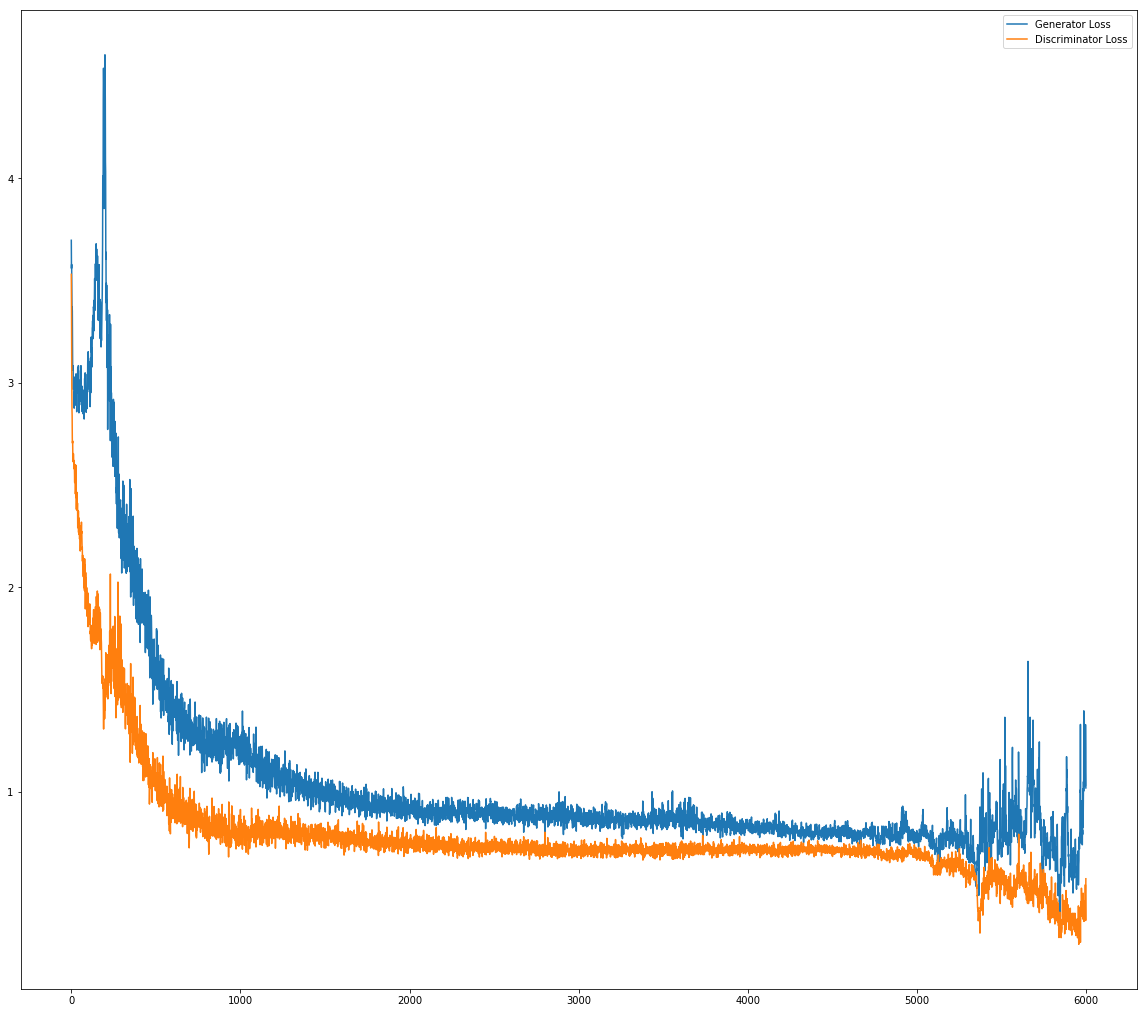

In [14]:
plt.figure(figsize=(20, 18))
plt.plot(train_loss_g, label="Generator Loss");
plt.plot(train_loss_d, label="Discriminator Loss");
plt.legend();

## Plot Accuracy

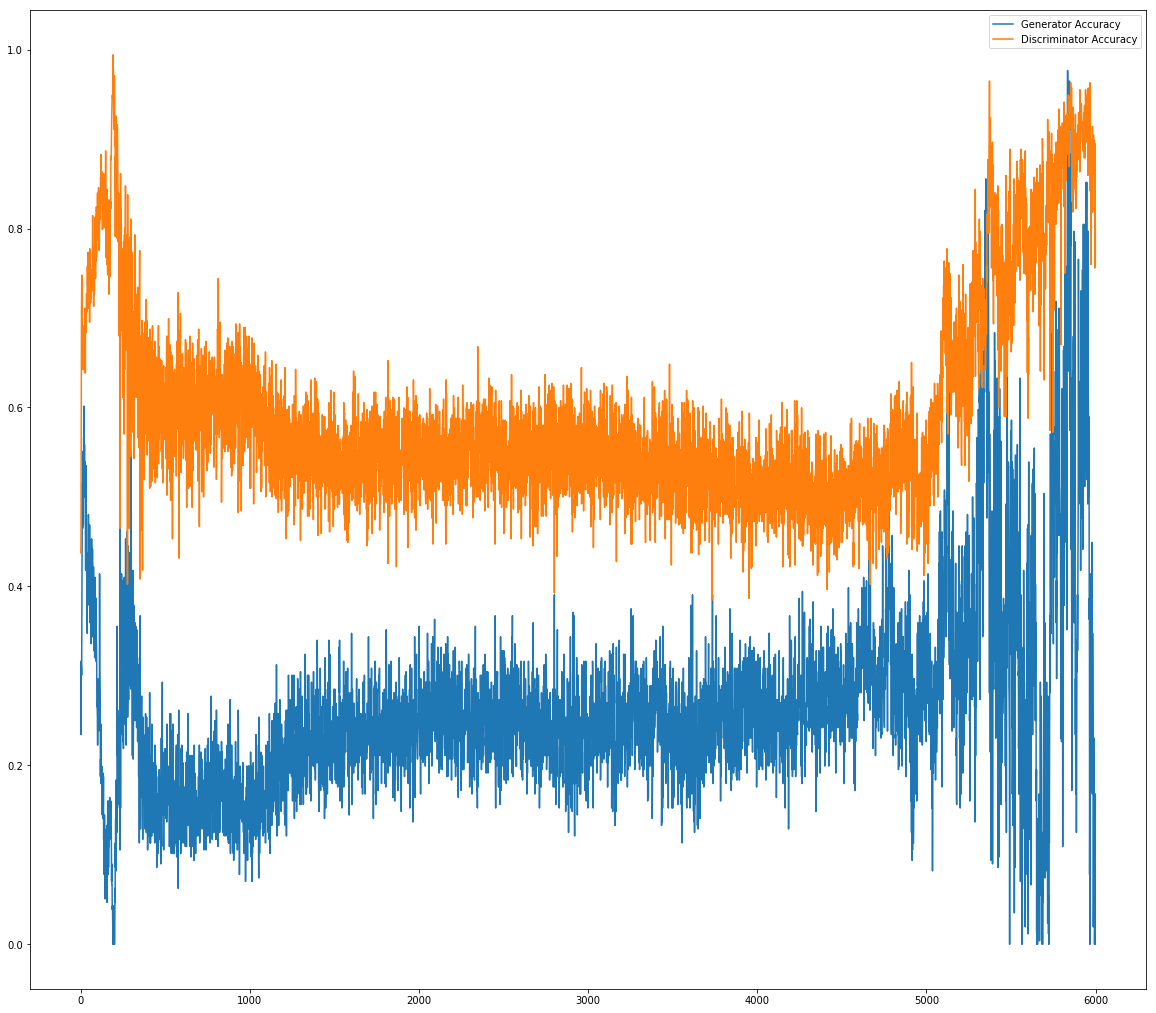

In [15]:
plt.figure(figsize=(20, 18))
plt.plot(train_acc_g, label="Generator Accuracy");
plt.plot(train_acc_d, label="Discriminator Accuracy");
plt.legend();

In [16]:
generator.save('./mnist-gen.h5')

In [17]:
discriminator.save('./mnist-disc.h5')

In [18]:
gan.save('./mnist-gan.h5')

In [19]:
gan.metrics_names

['loss', 'model_1_loss', 'model_1_loss', 'model_1_acc', 'model_1_acc_1']

In [20]:
## visualize results
synthesized = generator.predict([conditions, noise])
visualizeGAN(6000, None, synthesized, conditions)